In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
!pip install openpyxl
import os
import requests
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
!pip install libpysal
!pip install esda
!pip install pysal
from esda.getisord import G_Local
from libpysal.weights import Queen
from matplotlib.colors import SymLogNorm
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from scipy.stats import ttest_ind
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
  Using cached libpysal-4.13.0-py3-none-any.whl.metadata (4.8 kB)
Using cached libpysal-4.13.0-py3-none-any.whl (2.8 MB)
  Using cached pysal-25.1-py3-none-any.whl.metadata (15 kB)
  Using cached access-1.1.9-py3-none-any.whl.metadata (2.4 kB)
  Using cached giddy-2.3.6-py3-none-any.whl.metadata (6.3 kB)
  Using cached pointpats-2.5.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached segregation-2.5.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached spaghetti-1.7.6-py3-none-any.whl.metadata (12 kB)
  Using cached mgwr-2.2.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached momepy-0.10.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached spglm-1.1.0-py3-none-any.whl.meta

# Specifications

In [2]:
save = False
var = 'returnPeriod_MSWEP_1d'
optimal_cluster = 'st_cluster_3_5_7'

# Load County-Aggregated Policy Data

In [3]:
# Load aggregated sum policies by state
policies = pd.read_csv("../Local_Data/NFIP_Data/policy_total_county_averages.csv")

# Filter out rows with missing or blank values in the relevant columns
policies = policies.dropna(subset=['countyCode', 'policyCost_mean', 'totalInsurancePremiumOfThePolicy_mean'])
policies['countyCode'] = policies['countyCode'].astype(int).astype(str)
policies['countyCode'] = policies['countyCode'].apply(lambda x: str(x).zfill(5))
policies['oldest_year'] = policies['oldest_year'] -1 
policies['most_recent_year'] = policies['most_recent_year'] -1 

# Load Risk Rating 2.0 Data

In [4]:
risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

risk_policies['County'] = risk_policies['County'].str.strip()
risk_policies['State'] = risk_policies['State'].str.strip()

aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
    'Policies in Force': 'sum',
    'Total Coverage': 'sum',
    'Total Written Premium + FPF': 'sum',
    'Total Annual Payment': 'sum'
}).reset_index()

## Map Fips to appropriate county

In [5]:
# Read the file line by line
with open('../Local_Data/fips_codes.txt', 'r') as file:
    lines = file.readlines()

# Step 1: Identify where state-level data starts and ends
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # State data starts after the "state-level" heading
    if "county-level" in line.lower():
        county_section_start = i + 2  # County data starts after the "county-level" heading
        break

# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

# Step 1: Split the data into sections
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # Skip the header lines
    if "county-level" in line.lower():
        county_section_start = i + 2  # Skip the header lines
        break

state_lines = lines[state_section_start:county_section_start-2]  # State data lines
county_lines = lines[county_section_start:]  # County data line

# Step 3: Parse county data
county_fips = []
county_name = []

for line in county_lines:
    line = line.strip()
    if len(line) > 12 and line[:5].isdigit():
        county_fips_code = line[:5].strip()
        county_fips_name = line[12:].strip()
        county_fips.append(county_fips_code)
        county_name.append(county_fips_name)

county_df = pd.DataFrame({
    'countyCode': county_fips,
    'County Name': county_name
})

county_df['State FIPS'] = county_df['countyCode'].str[:2]  # Extract state FIPS from the countyCode

# Assuming county_df is already created and correctly populated:
fips_df = county_df.merge(state_df, on='State FIPS')
fips_df['County Name'] = fips_df['County Name'].str.upper()

# Final output
print("\nMerged FIPS DataFrame:")
print(fips_df.head())


Merged FIPS DataFrame:
  countyCode     County Name State FIPS State Name
0      01000         ALABAMA         01    ALABAMA
1      01001  AUTAUGA COUNTY         01    ALABAMA
2      01003  BALDWIN COUNTY         01    ALABAMA
3      01005  BARBOUR COUNTY         01    ALABAMA
4      01007     BIBB COUNTY         01    ALABAMA


In [6]:
# Step 1: Ensure that County and State names are fully capitalized in the aggregated_risk_policies DataFrame
aggregated_risk_policies['County'] = aggregated_risk_policies['County'].str.upper()
aggregated_risk_policies['State'] = aggregated_risk_policies['State'].str.upper()

# Step 2: Merge the DataFrames
aggregated_risk_policies = aggregated_risk_policies.merge(fips_df, left_on=['County', 'State'], right_on=['County Name', 'State Name'], how='left')

# Step 3: Drop unnecessary columns (optional)
aggregated_risk_policies = aggregated_risk_policies.drop(columns=['County Name', 'State Name'])

# Load Raw Claims Data

In [7]:
# Load claims data
claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")

# Create the new field 'percentageDamageAmount'
claims['percentageBuildingDamageAmount'] = ((claims['buildingDamageAmount'] / claims['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
claims['totalClaimPaid'] = claims['amountPaidOnBuildingClaim'].fillna(0) + claims['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
claims = claims[claims['stateOwnedIndicator'] != True]
# Create mitigated field
claims['mitigated'] = claims['elevatedBuildingIndicator'] | claims['floodproofedIndicator']

/tmp/ipykernel_2463/583556270.py:2: DtypeWarning: Columns (7,25,32,35,38,42,51,52,61) have mixed types. Specify dtype option on import or set low_memory=False.
  claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")


In [8]:
# Load claims data
claims1 = pd.read_csv("../2_Low_Return_Period/Clusters/no_percentile_filter/clustered_claims_sensitivity.csv")

# Create the new field 'percentageDamageAmount'
claims1['percentageBuildingDamageAmount'] = ((claims1['buildingDamageAmount'] / claims1['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
claims1['totalClaimPaid'] = claims1['amountPaidOnBuildingClaim'].fillna(0) + claims1['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
claims1 = claims1[claims1['stateOwnedIndicator'] != True]
# Create mitigated field
claims1['mitigated'] = claims1['elevatedBuildingIndicator'] | claims1['floodproofedIndicator']

# Ensure that 'countyCode' is properly formatted as a 5-character string
claims1['countyCode'] = claims1['countyCode'].astype(int).astype(str)
claims1['countyCode'] = claims1['countyCode'].apply(lambda x: str(x).zfill(5))

/tmp/ipykernel_2463/1126256585.py:2: DtypeWarning: Columns (8,26,33,36,39,43,52,53,62) have mixed types. Specify dtype option on import or set low_memory=False.
  claims1 = pd.read_csv("../2_Low_Return_Period/Clusters/no_percentile_filter/clustered_claims_sensitivity.csv")


In [9]:
# Load CPI data
CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"]) 
#CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/CPI_by_Year_Month.csv") for homeowners insurance CPI

# Ensure 'CPIAUCSL' is numeric
CPI_insurance["CPIAUCSL"] = pd.to_numeric(CPI_insurance["CPIAUCSL"], errors="coerce")

# Handle missing or non-numeric values by forward and backward filling
CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
CPI_insurance["CPIAUCSL"].fillna(method="bfill", inplace=True)

# Extract year and calculate annual average CPI
CPI_insurance['Year'] = CPI_insurance["DATE"].dt.year
CPI_insurance = CPI_insurance.groupby('Year')["CPIAUCSL"].mean().reset_index()
CPI_insurance = CPI_insurance.rename(columns={"CPIAUCSL": "CPI"})

# Base CPI for adjustment (e.g., 2024)
BASE_CPI = 313.3

# Filter claims to only include those from 1998 to present
claims['dateOfLoss'] = pd.to_datetime(claims['dateOfLoss'])

# Extract month (abbreviated) and year from 'dateOfLoss'
claims.loc[:, 'yearOfLoss'] = claims['dateOfLoss'].dt.year

# Merge claims with CPI_insurance on month (abbreviation) and year
claims_merged = pd.merge(claims, CPI_insurance, left_on=['yearOfLoss'], right_on=['Year'])

# Create 'adjustedClaim' column by dividing the CPI for May 2024 by the CPI at the time of loss, and multiplying by 'totalClaimPaid'
claims_merged['adjustedClaim'] = (BASE_CPI / claims_merged['CPI']) * claims_merged['totalClaimPaid']

# Drop unnecessary columns and keep relevant ones
adjusted_claims = claims_merged[['dateOfLoss', 'totalClaimPaid', 'adjustedClaim', 'yearOfLoss']]

claims = claims_merged

/tmp/ipykernel_2463/1154253428.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_2463/1154253428.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_2463/1154253428.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an

In [10]:
# Step 1: Group by 'Year' and calculate the sum of 'adjustedClaim'
grouped_claims = claims.groupby('Year')['adjustedClaim'].sum()

# Step 2: Subtract 3879323216 from each year's total
net_gain = 3879323216 - grouped_claims 

# Step 3: Copy the DataFrame
claims_masked = claims.copy()

# Step 4: Group by 'optimal_cluster' and sort by size
claims_masked = claims_masked[claims_masked[optimal_cluster] != -1]
grouped_clusters = (
    claims_masked.groupby(optimal_cluster)['adjustedClaim']
    .sum()
    .sort_values(ascending=False)
)

# Step 5: Print the top clusters
top_clusters = grouped_clusters[grouped_clusters > 1000000000]
print("Clusters with 'adjustedClaim' > 1,000,000,000:")
print(top_clusters)

# Step 6: Mask the datapoints in the billion-dollar clusters
mask = claims_masked[optimal_cluster].isin(top_clusters.index)
masked_claims = claims_masked[~mask]

# Step 7: Group by 'Year', sum 'adjustedClaim', and subtract fixed value
grouped_claims_masked = masked_claims.groupby('Year')['adjustedClaim'].sum()
adjusted_values = 3879323216 - grouped_claims_masked 

# Step 5: Print the top clusters
top_clusters_2 = grouped_clusters.head(8)
print("99.9% Clusters")
print(top_clusters_2)

# Step 6: Mask the datapoints in the top 5 clusters
mask_2 = claims_masked[optimal_cluster].isin(top_clusters_2.index)
masked_claims_2 = claims_masked[~mask_2]

# Step 7: Group by 'Year', sum 'adjustedClaim', and subtract fixed value
grouped_claims_masked_2 = masked_claims_2.groupby('Year')['adjustedClaim'].sum()
adjusted_values_2 = 3879323216 - grouped_claims_masked_2

Clusters with 'adjustedClaim' > 1,000,000,000:
st_cluster_3_5_7
4      2.542497e+10
87     1.166436e+10
327    1.146593e+10
166    4.991470e+09
8      3.649977e+09
295    3.280849e+09
6      2.628407e+09
190    2.410285e+09
312    1.865101e+09
91     1.825452e+09
158    1.424590e+09
342    1.196346e+09
Name: adjustedClaim, dtype: float64
99.9% Clusters
st_cluster_3_5_7
4      2.542497e+10
87     1.166436e+10
327    1.146593e+10
166    4.991470e+09
8      3.649977e+09
295    3.280849e+09
6      2.628407e+09
190    2.410285e+09
Name: adjustedClaim, dtype: float64


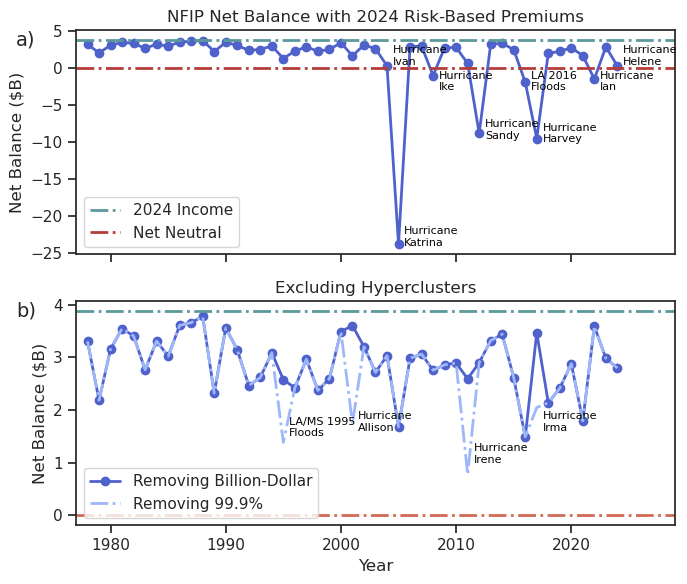

In [11]:
sns.set_theme(style="ticks")  # Ensures Seaborn styles are applied to all plots

# Step 8: Plot the stacked time series
fig, axes = plt.subplots(2, 1, figsize=(7.08, 6), sharex=True)

# Plot the first time series
axes[0].plot(net_gain.index, net_gain.values/1000000000, marker='o', color='#4F62CC', linewidth=2)
axes[0].axhline(3879323216/1000000000, color='#5B999B', linestyle='dashdot', linewidth=2, label='2024 Income')
axes[0].axhline(0, color='#B53D39', linestyle='dashdot', label='Net Neutral', linewidth=2)
axes[0].set_title('NFIP Net Balance with 2024 Risk-Based Premiums')
axes[0].set_ylabel('Net Balance ($B)')
#axes[0].grid(True)
axes[0].legend()
axes[0].text(-0.1, 1, "a)", transform=axes[0].transAxes, fontsize=14, va='top', ha='left')

# Add text labels to the first subplot
annotations = [
    (2004, 0.5, "Hurricane\nIvan"),
    (2005, -24, "Hurricane\nKatrina"),
    (2008, -3, "Hurricane\nIke"),
    (2012, -9.5, "Hurricane\nSandy"),
    (2016, -3, "LA 2016\nFloods"),
    (2017, -10, "Hurricane\nHarvey"),
    (2022, -3, "Hurricane\nIan"),
    (2024, 0.5, "Hurricane\nHelene")
]
for x, y, label in annotations:
    axes[0].text(x + 0.5, y, label, fontsize=8, color='black')

# Plot the second time series
axes[1].plot(adjusted_values.index, adjusted_values.values/1000000000, marker='o', label='Removing Billion-Dollar', color='#4F62CC', linewidth=2)
axes[1].plot(adjusted_values_2.index, adjusted_values_2.values/1000000000, color='#9EB7F9', linestyle='dashdot', label='Removing 99.9%', linewidth=2)
axes[1].axhline(3879323216/1000000000, color='#5B999B', linestyle='dashdot', linewidth=2)
axes[1].axhline(0, color='#D06A54', linestyle='dashdot', linewidth=2)
axes[1].set_title('Excluding Hyperclusters')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Net Balance ($B)')
axes[1].set_xlim([1977, 2029])
#axes[1].grid(True)
axes[1].legend()
axes[1].text(-0.1, 1, "b)", transform=axes[1].transAxes, fontsize=14, va='top', ha='left')


# Add text labels to the first subplot
annotations = [
    (1995, 1.5, "LA/MS 1995\nFloods"),
    (2001, 1.6, "Hurricane\nAllison"),
    (2011, 1, "Hurricane\nIrene"),
    (2017, 1.6, "Hurricane\nIrma")
]
for x, y, label in annotations:
    axes[1].text(x + 0.5, y, label, fontsize=8, color='black')

# Adjust layout
plt.tight_layout()
if save:
    output_path='Plots/F3_Time_Series.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')
plt.show()

# Load Shapefiles of Interest

In [12]:
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Data Merging and Preprocess

## State Contributions

In [13]:
state_claims = pd.read_csv('../Local_Data/NFIP_Data/All_Claims_by_Year.csv')
state_claims = state_claims.groupby("State").aggregate({'Total Claim Dollars Paid':'mean','Total Paid Claims':'mean'}).reset_index()
state_claims['State'] = state_claims['State'].str.upper()
state_claims = state_claims.merge(state_df, left_on='State', right_on='State Name', how='left')
state_policies = aggregated_risk_policies.groupby("State").aggregate({
    'Policies in Force':'sum',
    'Total Coverage':'sum',
    'Total Written Premium + FPF':'sum',
    'Total Annual Payment':'sum'}).reset_index()
state_merged = state_claims.merge(state_policies, left_on='State', right_on='State', how='left')
state_merged['meanLoss'] = state_merged['Total Written Premium + FPF']-state_merged['Total Claim Dollars Paid']

In [14]:
# Merge the aggregated data with the shapefile
gdf_states = gdf_states.merge(state_merged, left_on='GEOID', right_on='State FIPS', how='left')

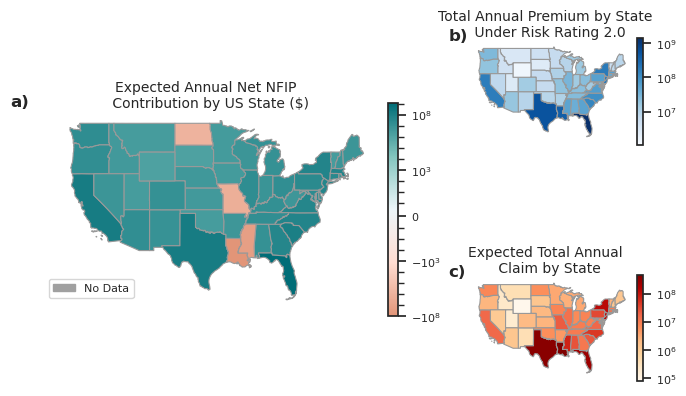

In [15]:
# Apply seaborn 'ticks' theme
sns.set_theme(style="ticks")

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Define the custom color palette for the first plot
colors = [
    '#e29578',  # Dark red for negative values
    '#ffddd2',  # Light red for negative values near 0
    '#edf6f9',  # Gray for values near 0
    '#83c5be',  # Light blue for positive values near 0
    '#006d77'   # Dark blue for positive values
]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Set the bounds for the colormap with an extended gray range
bounds = [-3000, -1000, 1000, 3000, 8207]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Apply a SymLogNorm for better handling of the extremes
linthresh = 1
sym_norm = mcolors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-94195870, vmax=1113542873, base=10)

# Create the grid layout with 2 rows and 2 columns, with the first column taking up more space
fig = plt.figure(figsize=(7, 5))  # 7 inches width (~180 mm), 5 inches height for aspect ratio
gs = GridSpec(2, 2, width_ratios=[2, 1])  # Make the left plot wider

# Plot 1: Expected Annual Net NFIP Contribution by US State
ax1 = fig.add_subplot(gs[:, 0])  # This takes up the entire first column

# Plot states with no data in lighter gray
no_data_color = '#a0a0a0'  # Slightly lighter gray
gdf_states[gdf_states['meanLoss'].isna()].plot(ax=ax1, color=no_data_color, edgecolor='0.6')

# Plot states with data
gdf_states[~gdf_states['meanLoss'].isna()].plot(column='meanLoss', cmap=cmap, linewidth=0.8, ax=ax1, edgecolor='0.6', norm=sym_norm)

# Add title and extent
ax1.set_title('Expected Annual Net NFIP \n Contribution by US State ($)', fontsize=10)
ax1.set_xlim(extent[0], extent[1])
ax1.set_ylim(extent[2], extent[3])
ax1.axis('off')

# Define the colorbar with the custom colormap and symmetrically log-scaled norm
sm = plt.cm.ScalarMappable(cmap=cmap, norm=sym_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_ticks([-100000000, -1000, 0, 1000, 100000000])
cbar.ax.tick_params(labelsize=8)

# Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
ax1.legend(handles=[no_data_patch], loc='lower left', fontsize=8)

# Add subplot label
ax1.text(-0.1, 1.05, 'a)', transform=ax1.transAxes, size=12, weight='bold')

# Plot 2: Total Written Premium + FPF
ax2 = fig.add_subplot(gs[0, 1])

# Define the color palette for this plot (Blues)
cmap_blues = plt.cm.Blues

# Apply a SymLogNorm to the 'Total Written Premium + FPF' column
sym_norm_blues = mcolors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=gdf_states['Total Written Premium + FPF'].min(), vmax=gdf_states['Total Written Premium + FPF'].max(), base=10)

# Plot states with no data
gdf_states[gdf_states['Total Written Premium + FPF'].isna()].plot(ax=ax2, color=no_data_color, edgecolor='0.6')

# Plot states with data
gdf_states[~gdf_states['Total Written Premium + FPF'].isna()].plot(column='Total Written Premium + FPF', cmap=cmap_blues, linewidth=0.8, ax=ax2, edgecolor='0.6', norm=sym_norm_blues)

# Add title and extent
ax2.set_title('Total Annual Premium by State \n Under Risk Rating 2.0', fontsize=10)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])
ax2.axis('off')

# Add colorbar for the second plot
sm_blues = plt.cm.ScalarMappable(cmap=cmap_blues, norm=sym_norm_blues)
sm_blues.set_array([])
cbar_blues = fig.colorbar(sm_blues, ax=ax2, orientation='vertical', fraction=0.03, pad=0.04)
cbar_blues.ax.tick_params(labelsize=8)

# Add subplot label
ax2.text(-0.1, 1.05, 'b)', transform=ax2.transAxes, size=12, weight='bold')

# Plot 3: Mean Total Claim Paid
ax3 = fig.add_subplot(gs[1, 1])

# Define the color palette for this plot (OrRd)
cmap_orange = plt.cm.OrRd

# Apply a SymLogNorm to the 'Total Claim Dollars Paid' column
sym_norm_orange = mcolors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=gdf_states['Total Claim Dollars Paid'].min(), vmax=gdf_states['Total Claim Dollars Paid'].max(), base=10)

# Plot states with no data
gdf_states[gdf_states['Total Claim Dollars Paid'].isna()].plot(ax=ax3, color=no_data_color, edgecolor='0.6')

# Plot states with data
gdf_states[~gdf_states['Total Claim Dollars Paid'].isna()].plot(column='Total Claim Dollars Paid', cmap=cmap_orange, linewidth=0.8, ax=ax3, edgecolor='0.6', norm=sym_norm_orange)

# Add title and extent
ax3.set_title('Expected Total Annual \n Claim by State', fontsize=10)
ax3.set_xlim(extent[0], extent[1])
ax3.set_ylim(extent[2], extent[3])
ax3.axis('off')

# Add colorbar for the third plot
sm_orange = plt.cm.ScalarMappable(cmap=cmap_orange, norm=sym_norm_orange)
sm_orange.set_array([])
cbar_orange = fig.colorbar(sm_orange, ax=ax3, orientation='vertical', fraction=0.03, pad=0.04)
cbar_orange.ax.tick_params(labelsize=8)

# Add subplot label
ax3.text(-0.1, 1.05, 'c)', transform=ax3.transAxes, size=12, weight='bold')

# Adjust layout for better spacing
plt.tight_layout(h_pad=0.5, w_pad=0.5)

# Save the plot with 500 dpi
if save:
    output_path = 'Plots/SI/Fig_1_by_state.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

## County Contributions

In [16]:
# Filter out rows with missing or blank values in the relevant columns
filtered_data = claims.dropna(subset=['countyCode', 'buildingDamageAmount', 'buildingPropertyValue', 'adjustedClaim', 'yearOfLoss'])
filtered_data['countyCode'] = filtered_data['countyCode'].astype(int).astype(str)
filtered_data['countyCode'] = filtered_data['countyCode'].apply(lambda x: str(x).zfill(5))
filtered_data['mitigatedClaim'] = filtered_data['elevatedBuildingIndicator'] | filtered_data['floodproofedIndicator']

# Aggregate the data by countyCode and yearOfLoss
aggregated_yearly_data = filtered_data.groupby(['countyCode', 'yearOfLoss']).agg({
    'adjustedClaim':'sum',
    'buildingDamageAmount': 'sum',
    'buildingPropertyValue': 'sum',
    'percentageBuildingDamageAmount': 'sum',
    'mitigatedClaim':'mean'
}).reset_index()

# Count the number of years available for each county and track min and max year
years_stats = aggregated_yearly_data.groupby('countyCode').agg({
    'yearOfLoss': ['count', 'min', 'max']
}).reset_index()

# Flatten the multi-level columns after aggregation
years_stats.columns = ['countyCode', 'years_averaged', 'min_yearOfLoss', 'max_yearOfLoss']

# Sum the yearly data across all years for each county
aggregated_county_data = aggregated_yearly_data.groupby('countyCode').agg({
    'adjustedClaim':'sum',
    'buildingDamageAmount': 'sum',
    'buildingPropertyValue': 'sum',
    'percentageBuildingDamageAmount': 'sum',
    'mitigatedClaim':'mean'
}).reset_index()

# Merge with the years_stats to keep track of the number of years averaged over, min, and max years
aggregated_county_data = pd.merge(aggregated_county_data, years_stats, on='countyCode')

# Merge the two DataFrames on 'countyCode'
merged_data = pd.merge(aggregated_county_data, policies, on='countyCode', how='inner', suffixes=('_claims', '_policies'))

# Calculate the minimum of the two min_yearOfLoss and the maximum of the two max_yearOfLoss
merged_data['min_yearOfLoss'] = merged_data[['min_yearOfLoss', 'oldest_year']].min(axis=1)
merged_data['max_yearOfLoss'] = merged_data[['max_yearOfLoss', 'most_recent_year']].max(axis=1)

# Calculate the total number of years (max - min + 1)
merged_data['total_years'] = merged_data['max_yearOfLoss'] - merged_data['min_yearOfLoss'] + 1

# Drop the original min/max columns if no longer needed
merged_data = merged_data.drop(columns=['min_yearOfLoss', 'oldest_year', 'max_yearOfLoss', 'most_recent_year'])

# Calculate the mean yearly value by dividing by the actual number of years present for each county
merged_data['mean_adjustedClaim'] = merged_data['adjustedClaim'] / merged_data['total_years']
merged_data['mean_buildingDamageAmount'] = merged_data['buildingDamageAmount'] / merged_data['total_years']
merged_data['mean_buildingPropertyValue'] = merged_data['buildingPropertyValue'] / merged_data['total_years']
merged_data['mean_percentageBuildingDamageAmount'] = merged_data['percentageBuildingDamageAmount'] / merged_data['total_years']

# Reset index to keep the final structure
merged_data.reset_index(drop=True, inplace=True)

# Mean Loss
merged_data['meanLoss_hist'] = merged_data['totalInsurancePremiumOfThePolicy_mean']-merged_data['mean_adjustedClaim']

In [17]:
# Merge the two DataFrames on 'countyCode'
merged_data = pd.merge(merged_data, aggregated_risk_policies, on='countyCode', how='inner', suffixes=('_claims', '_policies'))

# Mean Loss
merged_data['meanLoss'] = merged_data['Total Written Premium + FPF']-merged_data['mean_adjustedClaim']

# Loss per HH Insured
merged_data['lossPerInsured'] = merged_data['meanLoss']/merged_data['Policies in Force']

# Now you can save or use the merged data
merged_data.to_csv('nfip_merged_county_data_RR2.csv', index=False)

# Merge the aggregated data with the shapefile
gdf_counties = gdf_counties.merge(merged_data, left_on='GEOID', right_on='countyCode', how='left')

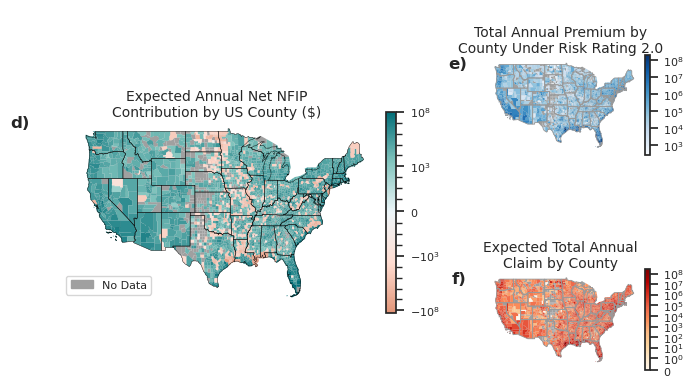

In [18]:
# Set seaborn theme
sns.set_theme(style="ticks")

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Define the custom color palette for the first plot
colors = [
    '#e29578',  # Dark red for negative values
    '#ffddd2',  # Light red for negative values near 0
    '#edf6f9',  # Gray for values near 0
    '#83c5be',  # Light blue for positive values near 0
    '#006d77'   # Dark blue for positive values
]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Set the bounds for the colormap with an extended gray range
bounds = [-3000, -1000, 1000, 3000, 8207]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Apply a SymLogNorm for better handling of the extremes
linthresh = 1
sym_norm = mcolors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-179965441, vmax=106213551, base=10)

# Set figure size (180 mm width, approximate height)
fig = plt.figure(figsize=(7.1, 4.7))  # 180 mm width = 7.1 inches
gs = GridSpec(2, 2, width_ratios=[2, 1])  # Make the left plot wider

# Plot 1: Expected Annual Net NFIP Contribution by US County
ax1 = fig.add_subplot(gs[:, 0])  # This takes up the entire first column

# Plot counties with no data in lighter gray
no_data_color = '#a0a0a0'  # Slightly lighter gray
gdf_counties[gdf_counties['meanLoss'].isna()].plot(ax=ax1, color=no_data_color, linewidth=0.01, edgecolor='0.6')

# Plot counties with data
gdf_counties[~gdf_counties['meanLoss'].isna()].plot(column='meanLoss', cmap=cmap, linewidth=0.01, ax=ax1, edgecolor='0.1', norm=sym_norm)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.3)

# Add title, extent, and label
ax1.set_title('Expected Annual Net NFIP\nContribution by US County ($)', fontsize=10)
ax1.set_xlim(extent[0], extent[1])
ax1.set_ylim(extent[2], extent[3])
ax1.axis('off')
ax1.text(-0.1, 1.05, 'd)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Define the colorbar with the custom colormap and symmetrically log-scaled norm
sm = plt.cm.ScalarMappable(cmap=cmap, norm=sym_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.03, pad=0.04)  # Adjusted fraction and pad
cbar.set_ticks([-100000000, -1000, 0, 1000, 100000000])
cbar.ax.tick_params(labelsize=8)

# Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
ax1.legend(handles=[no_data_patch], loc='lower left', fontsize=8)

# Plot 2: Total Written Premium + FPF
ax2 = fig.add_subplot(gs[0, 1])

# Define the color palette for this plot (Blues)
cmap_blues = plt.cm.Blues

# Apply a SymLogNorm to the 'Total Written Premium + FPF' column
sym_norm_blues = mcolors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=gdf_counties['Total Written Premium + FPF'].min(), vmax=gdf_counties['Total Written Premium + FPF'].max(), base=10)

# Plot counties with no data
gdf_counties[gdf_counties['Total Written Premium + FPF'].isna()].plot(ax=ax2, color=no_data_color, linewidth=0.01, edgecolor='0.6')

# Plot counties with data
gdf_counties[~gdf_counties['Total Written Premium + FPF'].isna()].plot(column='Total Written Premium + FPF', cmap=cmap_blues, linewidth=0.01, ax=ax2, edgecolor='0.1', norm=sym_norm_blues)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax2, edgecolor='0.6', linewidth=0.6)

# Add title, extent, and label
ax2.set_title(' \nTotal Annual Premium by\nCounty Under Risk Rating 2.0', fontsize=10)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])
ax2.axis('off')
ax2.text(-0.1, 1.05, 'e)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Add colorbar for the second plot
sm_blues = plt.cm.ScalarMappable(cmap=cmap_blues, norm=sym_norm_blues)
sm_blues.set_array([])
cbar_blues = fig.colorbar(sm_blues, ax=ax2, orientation='vertical', fraction=0.03, pad=0.04)
cbar_blues.ax.tick_params(labelsize=8)

# Plot 3: Mean Total Claim Paid
ax3 = fig.add_subplot(gs[1, 1])

# Define the color palette for this plot (OrRd)
cmap_orange = plt.cm.OrRd

# Apply a SymLogNorm to the 'mean_adjustedClaim' column
sym_norm_orange = mcolors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=gdf_counties['mean_adjustedClaim'].min(), vmax=gdf_counties['mean_adjustedClaim'].max(), base=10)

# Plot counties with no data
gdf_counties[gdf_counties['mean_adjustedClaim'].isna()].plot(ax=ax3, color=no_data_color, linewidth=0.01, edgecolor='0.6')

# Plot counties with data
gdf_counties[~gdf_counties['mean_adjustedClaim'].isna()].plot(column='mean_adjustedClaim', cmap=cmap_orange, linewidth=0.01, ax=ax3, edgecolor='0.1', norm=sym_norm_orange)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax3, edgecolor='0.6', linewidth=0.6)

# Add title, extent, and label
ax3.set_title('Expected Total Annual\nClaim by County', fontsize=10)
ax3.set_xlim(extent[0], extent[1])
ax3.set_ylim(extent[2], extent[3])
ax3.axis('off')
ax3.text(-0.1, 1.05, 'f)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Add colorbar for the third plot
sm_orange = plt.cm.ScalarMappable(cmap=cmap_orange, norm=sym_norm_orange)
sm_orange.set_array([])
cbar_orange = fig.colorbar(sm_orange, ax=ax3, orientation='vertical', fraction=0.03, pad=0.04)
cbar_orange.ax.tick_params(labelsize=8)

# Adjust layout for better spacing
plt.tight_layout(h_pad=0.5, w_pad=0.5)

# Save the plot with 500 dpi
if save:
    output_path = 'Plots/SI/Fig_1_by_county.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

In [19]:
# Ike Adjustment
ike = 8
ike_numbers = [178, 4193, 1923, 1276]
claims[optimal_cluster] = claims[optimal_cluster].apply(
    lambda x: ike if x in ike_numbers else x
)

In [20]:
top_clusters.index

Index([4, 87, 327, 166, 8, 295, 6, 190, 312, 91, 158, 342], dtype='int64', name='st_cluster_3_5_7')

In [21]:
billion_dollar_claims1 = claims1[claims1[optimal_cluster].isin([4,76,277,8,248,6,263,78,125,291])]

billion_dollar_claims1['countyCode'] = billion_dollar_claims1['countyCode'].astype(int).astype(str)
billion_dollar_claims1['countyCode'] = billion_dollar_claims1['countyCode'].apply(lambda x: str(x).zfill(5))

/tmp/ipykernel_2463/4174509608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billion_dollar_claims1['countyCode'] = billion_dollar_claims1['countyCode'].astype(int).astype(str)
/tmp/ipykernel_2463/4174509608.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billion_dollar_claims1['countyCode'] = billion_dollar_claims1['countyCode'].apply(lambda x: str(x).zfill(5))


In [22]:
billion_dollar_claims = claims[claims[optimal_cluster].isin(top_clusters.index)]

billion_dollar_claims['countyCode'] = billion_dollar_claims['countyCode'].astype(int).astype(str)
billion_dollar_claims['countyCode'] = billion_dollar_claims['countyCode'].apply(lambda x: str(x).zfill(5))

# Step 1: Count the number of rows associated with each 'countyCode'
hyper_count = billion_dollar_claims.groupby('countyCode').size().reset_index(name='hyperCount')

# Step 2: Merge the 'hyper_count' column with 'gdf_counties' on 'GEOID' using 'countyCode'
# Assuming 'gdf_counties' is your GeoDataFrame or DataFrame
gdf_counties = gdf_counties.merge(hyper_count, left_on='GEOID', right_on='countyCode', how='left', suffixes=('', '_drop'))

# Step 4: Drop the duplicate 'countyCode_drop' column from the merge
gdf_counties.drop(columns=['countyCode_drop'], inplace=True, errors='ignore')

/tmp/ipykernel_2463/3518132961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billion_dollar_claims['countyCode'] = billion_dollar_claims['countyCode'].astype(int).astype(str)
/tmp/ipykernel_2463/3518132961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billion_dollar_claims['countyCode'] = billion_dollar_claims['countyCode'].apply(lambda x: str(x).zfill(5))


In [23]:
# Define spatial weights
w = Queen.from_dataframe(gdf_counties)
w.transform = 'r'  # Row-standardized weights

# Handle missing values (replace with 0 if necessary)
gdf_counties['hyperCount'] = gdf_counties['hyperCount'].fillna(0)

# Perform Getis-Ord analysis
attribute = gdf_counties['hyperCount'].values
g_local = G_Local(attribute, w)

# Add results to GeoDataFrame
gdf_counties['G_Statistic_hyperCount'] = g_local.Gs
gdf_counties['Z_Scores_hyperCount'] = g_local.z_sim
gdf_counties['P_Values_hyperCount'] = g_local.p_sim

/tmp/ipykernel_2463/1665891882.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_counties)
/srv/conda/envs/notebook/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
 There are 10 islands with ids: 365, 800, 891, 964, 1248, 1926, 2082, 2736, 3102, 3209.
  W.__init__(self, neighbors, ids=ids, **kw)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)


('WARNING: ', 365, ' is an island (no neighbors)')
('WARNING: ', 800, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 964, ' is an island (no neighbors)')
('WARNING: ', 1248, ' is an island (no neighbors)')
('WARNING: ', 1926, ' is an island (no neighbors)')
('WARNING: ', 2082, ' is an island (no neighbors)')
('WARNING: ', 2736, ' is an island (no neighbors)')
('WARNING: ', 3102, ' is an island (no neighbors)')
('WARNING: ', 3209, ' is an island (no neighbors)')


/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


/tmp/ipykernel_2463/2514355684.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)


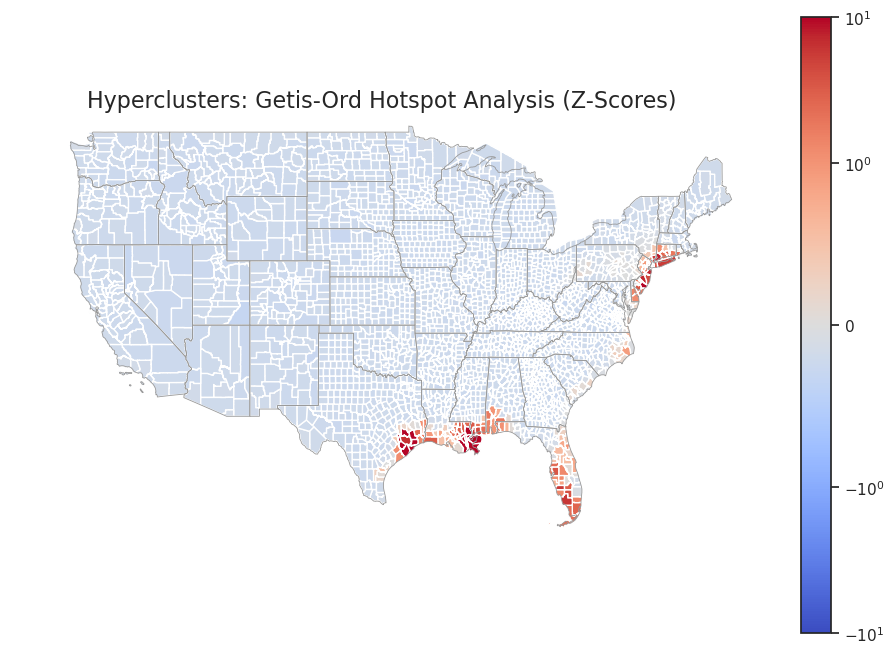

In [24]:
# Plot Z-Scores
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
cmap = plt.cm.get_cmap('coolwarm')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_hyperCount', norm=norm, cmap=cmap, legend=True, ax=ax)
# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor='0.6', linewidth=0.6)
ax.set_title('Hyperclusters: Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')
plt.show()

In [25]:
# Define spatial weights
w = Queen.from_dataframe(gdf_counties)
w.transform = 'r'  # Row-standardized weights

# Handle missing values (replace with 0 if necessary)
gdf_counties['meanLoss'] = gdf_counties['meanLoss'].fillna(0)

# Perform Getis-Ord analysis
attribute = gdf_counties['meanLoss'].values
g_local = G_Local(attribute, w)

# Add results to GeoDataFrame
gdf_counties['G_Statistic_meanLoss'] = g_local.Gs
gdf_counties['Z_Scores_meanLoss'] = g_local.z_sim
gdf_counties['P_Values_meanLoss'] = g_local.p_sim

/tmp/ipykernel_2463/1694318208.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_counties)


('WARNING: ', 365, ' is an island (no neighbors)')
('WARNING: ', 800, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 964, ' is an island (no neighbors)')
('WARNING: ', 1248, ' is an island (no neighbors)')
('WARNING: ', 1926, ' is an island (no neighbors)')
('WARNING: ', 2082, ' is an island (no neighbors)')
('WARNING: ', 2736, ' is an island (no neighbors)')
('WARNING: ', 3102, ' is an island (no neighbors)')
('WARNING: ', 3209, ' is an island (no neighbors)')


/srv/conda/envs/notebook/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
 There are 10 islands with ids: 365, 800, 891, 964, 1248, 1926, 2082, 2736, 3102, 3209.
  W.__init__(self, neighbors, ids=ids, **kw)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


/tmp/ipykernel_2463/2516242662.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)


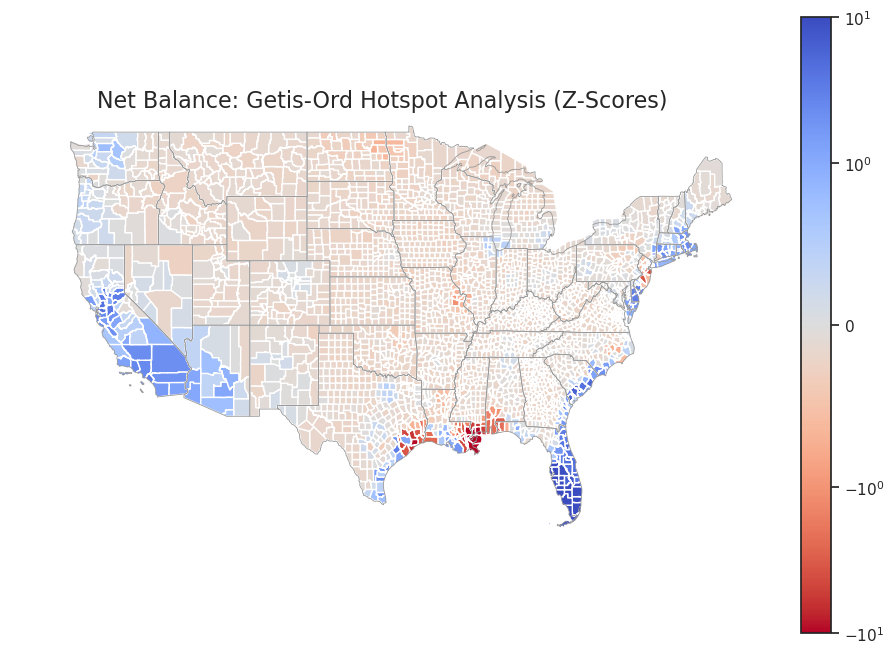

In [26]:
# Plot Z-Scores
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
cmap = plt.cm.get_cmap('coolwarm_r')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_meanLoss', norm=norm, cmap=cmap, legend=True, ax=ax)
# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor='0.6', linewidth=0.6)
ax.set_title('Net Balance: Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')
plt.show()

/tmp/ipykernel_2463/3077498138.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r')


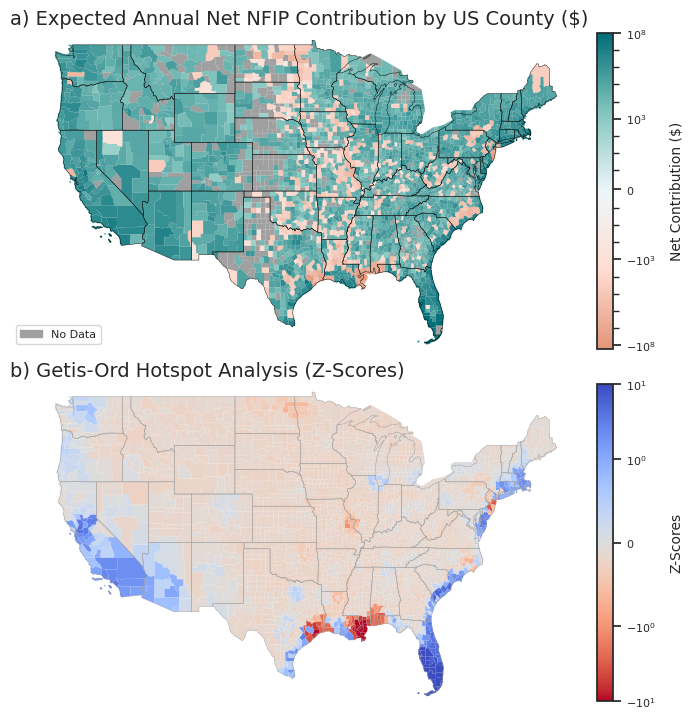

In [27]:
# Create the figure and axes for the subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.08, 7.08), constrained_layout=True)

# Plot 1: Expected Annual Net NFIP Contribution by US County ($)
# Define the custom color palette for the first plot
colors = [
    '#e29578',  # Dark red for negative values
    '#ffddd2',  # Light red for negative values near 0
    '#edf6f9',  # Gray for values near 0
    '#83c5be',  # Light blue for positive values near 0
    '#006d77'   # Dark blue for positive values
]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
linthresh = 1
sym_norm = mcolors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-179965441, vmax=106213551, base=10)

no_data_color = '#a0a0a0'  # Slightly lighter gray

# Create a mask for counties that had originally missing 'meanLoss' values (now filled with 0)
no_data_mask = gdf_counties['meanLoss'] == 0

# Plot counties that originally had no data with the NA color
gdf_counties[no_data_mask].plot(ax=ax1, color=no_data_color, linewidth=0.01, edgecolor='0.6')

# Plot counties with data (excluding those marked as "No Data")
gdf_counties[~no_data_mask].plot(column='meanLoss', cmap=cmap, linewidth=0.01, ax=ax1, edgecolor='0.1', norm=sym_norm)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.3)

# Add title, extent, and label
ax1.set_title('a) Expected Annual Net NFIP Contribution by US County ($)', fontsize=14, loc='left')
ax1.set_xlim(-130, -65)
ax1.set_ylim(24, 50)
ax1.axis('off')
#ax1.text(-0.1, 1.05, 'a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
ax1.legend(handles=[no_data_patch], loc='lower left', fontsize=8)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=sym_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_ticks([-100000000, -1000, 0, 1000, 100000000])
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Net Contribution ($)', fontsize=10, labelpad=10)

# Plot 2: Z-Scores (Getis-Ord Hotspot Analysis)
cmap = plt.cm.get_cmap('coolwarm_r')
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_meanLoss', linewidth=0.01, norm=norm, cmap=cmap, ax=ax2)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax2, edgecolor='0.6', linewidth=0.3)

# Add a custom colorbar
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', fraction=0.03, pad=0.04)
cbar2.set_ticks([-10, -1, 0, 1, 10])
cbar2.ax.tick_params(labelsize=8)
cbar2.set_label('Z-Scores', fontsize=10, labelpad=10)

# Add title, extent, and label
ax2.set_title('b) Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=14, loc='left')
ax2.set_xlim(-130, -65)
ax2.set_ylim(24, 50)
ax2.axis('off')
#ax2.text(-0.1, 1.05, 'b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Show the final combined plot
if save:
    output_path = 'Plots/F1_Net_Contribution_Hotspot.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')
plt.show()

# Unclustered Claims

In [28]:
# Step 1: Filter claims to only include rows where optimal_cluster == -1
filtered_claims = claims[claims[optimal_cluster] == -1]
filtered_claims['countyCode'] = filtered_claims['countyCode'].astype(int).astype(str)
filtered_claims['countyCode'] = filtered_claims['countyCode'].apply(lambda x: str(x).zfill(5))

# Step 2: Group by 'countyCode' and count the number of datapoints
cluster_counts = filtered_claims.groupby('countyCode').size().reset_index(name='countUncluster')

# Step 3: Merge the grouped counts with gdf_counties based on 'countyCode' and 'GEOID'
gdf_counties = gdf_counties.merge(cluster_counts, left_on='GEOID', right_on='countyCode', how='left', suffixes=('', '_drop'))

# Step 4: Drop the duplicate 'countyCode_drop' column from the merge
gdf_counties.drop(columns=['countyCode_drop'], inplace=True, errors='ignore')

# Step 5: Replace NaN values with 0 (for counties with no data points)
gdf_counties['countUncluster'] = gdf_counties['countUncluster'].fillna(0)

/tmp/ipykernel_2463/2005028575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_claims['countyCode'] = filtered_claims['countyCode'].astype(int).astype(str)
/tmp/ipykernel_2463/2005028575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_claims['countyCode'] = filtered_claims['countyCode'].apply(lambda x: str(x).zfill(5))


In [29]:
# Define spatial weights
w = Queen.from_dataframe(gdf_counties)
w.transform = 'r'  # Row-standardized weights

# Handle missing values (replace with 0 if necessary)
gdf_counties['countUncluster'] = gdf_counties['countUncluster'].fillna(0)

# Perform Getis-Ord analysis
attribute = gdf_counties['countUncluster'].values
g_local = G_Local(attribute, w)

# Add results to GeoDataFrame
gdf_counties['G_Statistic_countUncluster'] = g_local.Gs
gdf_counties['Z_Scores_countUncluster'] = g_local.z_sim
gdf_counties['P_Values_countUncluster'] = g_local.p_sim

/tmp/ipykernel_2463/3489756358.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_counties)


('WARNING: ', 365, ' is an island (no neighbors)')
('WARNING: ', 800, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 964, ' is an island (no neighbors)')
('WARNING: ', 1248, ' is an island (no neighbors)')
('WARNING: ', 1926, ' is an island (no neighbors)')
('WARNING: ', 2082, ' is an island (no neighbors)')
('WARNING: ', 2736, ' is an island (no neighbors)')
('WARNING: ', 3102, ' is an island (no neighbors)')
('WARNING: ', 3209, ' is an island (no neighbors)')


/srv/conda/envs/notebook/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
 There are 10 islands with ids: 365, 800, 891, 964, 1248, 1926, 2082, 2736, 3102, 3209.
  W.__init__(self, neighbors, ids=ids, **kw)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


/tmp/ipykernel_2463/1316652723.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)


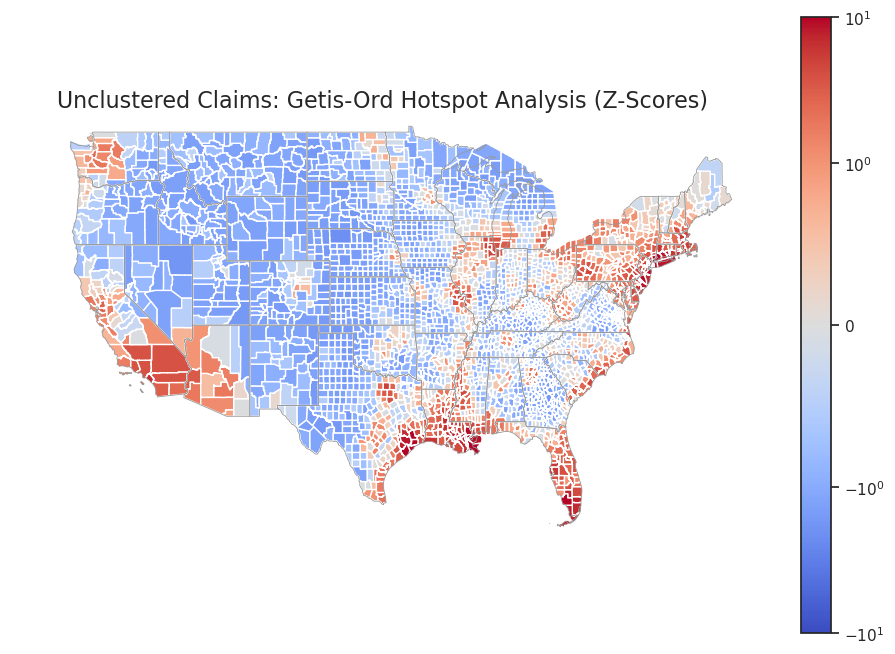

In [30]:
# Plot Z-Scores
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
cmap = plt.cm.get_cmap('coolwarm')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_countUncluster', norm=norm, cmap=cmap, legend=True, ax=ax)
# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor='0.6', linewidth=0.6)
ax.set_title('Unclustered Claims: Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')
plt.show()

/tmp/ipykernel_2463/3883799773.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


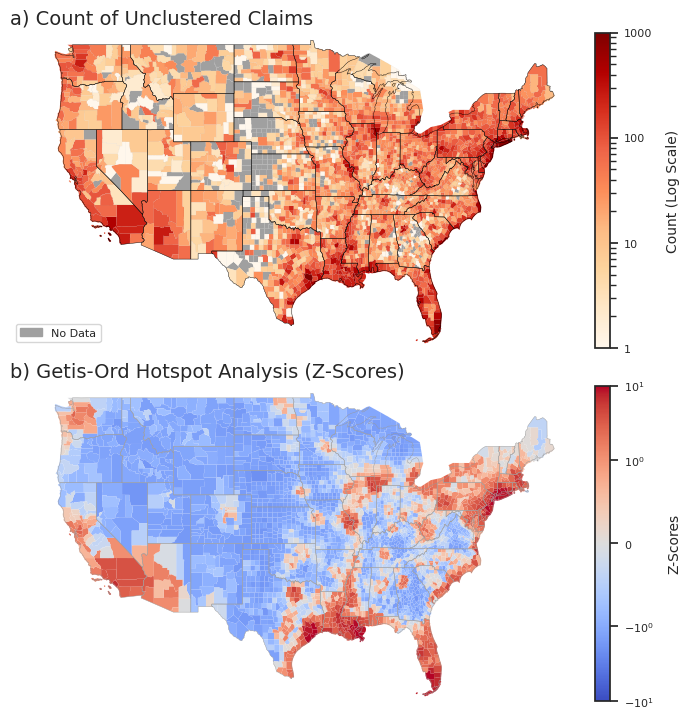

In [31]:
cmap = plt.cm.OrRd

# Define the log-normal scale
log_norm = mcolors.LogNorm(vmin=1, vmax=1000)

# Define the color for counties with no data
no_data_color = '#a0a0a0'  # Slightly lighter gray

# Create the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.08, 7.08), constrained_layout=True)

# Step 1: Plot counties with no data (masked as 'No Data')
no_data_mask = gdf_counties['countUncluster'] == 0
gdf_counties[no_data_mask].plot(ax=ax1, color=no_data_color, linewidth=0.01, edgecolor='0.6')

# Step 2: Plot counties with data using the log-normal scale
gdf_counties[~no_data_mask].plot(column='countUncluster', cmap=cmap, linewidth=0.01, ax=ax1, edgecolor='0.1', norm=log_norm)

# Step 3: Plot state borders
gdf_states.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.3)

# Step 4: Add title, extent, and axis properties
ax1.set_title('a) Count of Unclustered Claims', fontsize=14, loc='left')
ax1.set_xlim(-130, -65)
ax1.set_ylim(24, 50)
ax1.axis('off')

# Step 5: Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
ax1.legend(handles=[no_data_patch], loc='lower left', fontsize=8)

# Step 6: Add colorbar for log scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=log_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_ticks([1, 10, 100, 1000])
cbar.ax.set_yticklabels(['1', '10', '100', '1000'])
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Count (Log Scale)', fontsize=10, labelpad=10)

# Plot 2: Z-Scores (Getis-Ord Hotspot Analysis)
cmap = plt.cm.get_cmap('coolwarm')
norm = mcolors.SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_countUncluster', linewidth=0.01, norm=norm, cmap=cmap, ax=ax2)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax2, edgecolor='0.6', linewidth=0.3)

# Add a custom colorbar
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', fraction=0.03, pad=0.04)
cbar2.set_ticks([-10, -1, 0, 1, 10])
cbar2.ax.tick_params(labelsize=8)
cbar2.set_label('Z-Scores', fontsize=10, labelpad=10)

# Add title, extent, and label
ax2.set_title('b) Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=14, loc='left')
ax2.set_xlim(-130, -65)
ax2.set_ylim(24, 50)
ax2.axis('off')

# Show the final combined plot
if save:
    output_path = 'Plots/Net_Contribution_Hotspot.png'
    #plt.savefig(output_path, dpi=500, bbox_inches='tight')
plt.show()

## Multiple Loss Properties

In [32]:
multi_loss = pd.read_csv('../Local_Data/NFIP_Data/NfipMultipleLossProperties.csv')

In [33]:
# Ensure the countyCode is a string with leading zeros if needed
multi_loss = multi_loss.dropna(subset=['fipsCountyCode'])
multi_loss['fipsCountyCode'] = multi_loss['fipsCountyCode'].astype(int).astype(str)
multi_loss['fipsCountyCode'] = multi_loss['fipsCountyCode'].apply(lambda x: str(x).zfill(5))

county_multi_loss = multi_loss.groupby("fipsCountyCode").aggregate({
    'nfipRl':'sum',
    'nfipSrl':'sum',
    'fmaRl':'sum',
    'fmaSrl':'sum',
    'totalLosses':'sum',
    'primaryResidenceIndicator':'sum',
    'mitigatedIndicator':'sum',
    'insuredIndicator':'sum'}).reset_index()
county_multi_loss['Rl'] = county_multi_loss['nfipRl']+county_multi_loss['fmaRl']
county_multi_loss['Srl'] = county_multi_loss['nfipSrl']+county_multi_loss['fmaSrl']
county_multi_loss['totalMultiLossProp'] = county_multi_loss['Rl']+county_multi_loss['Srl']
# Avoid division by zero by using np.where
county_multi_loss['lossPerProp'] = np.where(county_multi_loss['totalMultiLossProp'] != 0,
                                            county_multi_loss['totalLosses'] / county_multi_loss['totalMultiLossProp'],
                                            0)

county_multi_loss['percentInsured'] = np.where(
    county_multi_loss['totalMultiLossProp'] != 0,
    (county_multi_loss['insuredIndicator'] / county_multi_loss['totalMultiLossProp'] * 100).clip(upper=100),
    0
)

county_multi_loss['percentMitigated'] = np.where(
    county_multi_loss['totalMultiLossProp'] != 0,
    (county_multi_loss['mitigatedIndicator'] / county_multi_loss['totalMultiLossProp'] * 100).clip(upper=100),
    0
)

county_multi_loss['percentPrimaryResidence'] = np.where(
    county_multi_loss['totalMultiLossProp'] != 0,
    (county_multi_loss['primaryResidenceIndicator'] / county_multi_loss['totalMultiLossProp'] * 100).clip(upper=100),
    0
)

# Load the shapefile for US counties
#shapefile_path = '../Local_Data/Geospatial/tl_2023_us_county.shp'
#gdf_counties = gpd.read_file(shapefile_path)

# Merge the aggregated data with the shapefile
gdf_counties = gdf_counties.merge(county_multi_loss, left_on='GEOID', right_on='fipsCountyCode', how='left')

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

In [34]:
def plot_panel(ax, gdf_counties, gdf_states, column, title, cmap=plt.cm.OrRd, log_scale=False, log_min=None, vmin_clip=None, vmax_clip=None):
    vmin = gdf_counties[column].min()
    vmax = gdf_counties[column].max()

    if vmin_clip is not None:
        vmin = vmin_clip
    if vmax_clip is not None:
        vmax = vmax_clip

    if log_scale:
        if log_min is not None:
            vmin = log_min
        else:
            vmin = max(1, vmin)
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = Normalize(vmin=vmin, vmax=vmax)  # <--- Fix: explicitly control linear scale

    no_data_color = '#a0a0a0'

    # Plot counties with no data
    gdf_counties[gdf_counties[column].isna()].plot(ax=ax, color=no_data_color, edgecolor='0.6')

    # Plot counties with data
    gdf_counties[~gdf_counties[column].isna()].plot(
        column=column, cmap=cmap, linewidth=0.1, ax=ax, edgecolor='0.6', norm=norm
    )

    gdf_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

    ax.set_title(title, fontsize=10)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
    if 'percent' in title.lower():
        cbar.set_label('%')
    elif 'loss per' in title.lower():
        cbar.set_label('Average Losses per Property')
    else:
        cbar.set_label('Count')

    # Add custom legend for No Data
    no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
    ax.legend(handles=[no_data_patch], loc='lower left', fontsize=8)

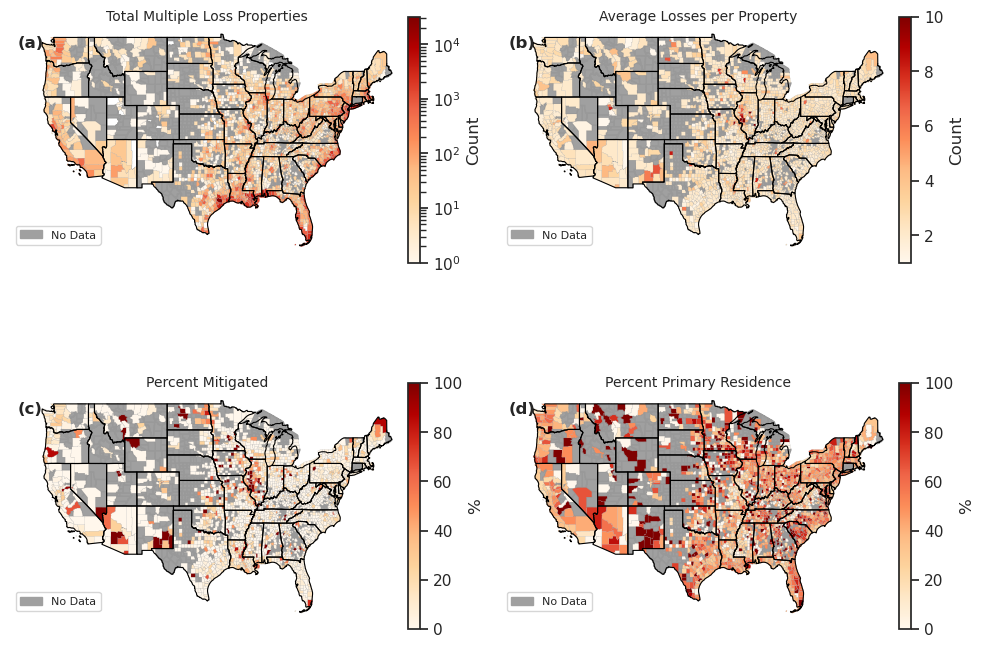

In [35]:
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot 1: Total Counts of Multiple Loss Properties (log scale)
plot_panel(
    axes[0, 0], gdf_counties, gdf_states, 'totalMultiLossProp',
    'Total Multiple Loss Properties', log_scale=True, log_min=1
)

# Plot 2: Average Losses per Property (linear scale, optional clipping)
plot_panel(
    axes[0, 1], gdf_counties, gdf_states, 'lossPerProp',
    'Average Losses per Property', log_scale=False, vmin_clip=1, vmax_clip=10  # Optional: clip colorbar to 1-10
)

# Plot 3: Percent Mitigated
plot_panel(
    axes[1, 0], gdf_counties, gdf_states, 'percentMitigated',
    'Percent Mitigated'
)

# Plot 4: Percent Primary Residence
plot_panel(
    axes[1, 1], gdf_counties, gdf_states, 'percentPrimaryResidence',
    'Percent Primary Residence'
)

# Add panel labels
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axes.flat, panel_labels):
    ax.text(
        0.02, 0.97, label,
        transform=ax.transAxes,
        fontsize=12, fontweight='bold',
        va='top', ha='left'
    )

plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for suptitle

if save:
    output_path = 'Plots/SI/Multi_Loss_Chars.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

plt.show()

In [55]:
county_multi_loss['percentPrimaryResidence'].mean()

np.float64(43.981310346826376)

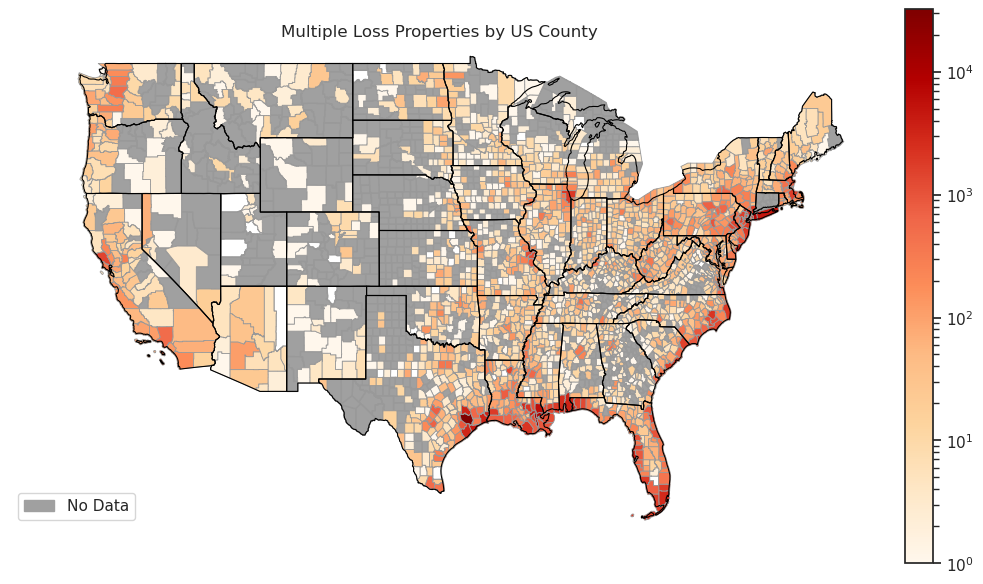

In [34]:
# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Change the color palette to OrRd for non-negative values
cmap = plt.cm.OrRd

# Set vmin and vmax based on the range of your data
vmin = gdf_counties['totalMultiLossProp'].min()+1
vmax = gdf_counties['totalMultiLossProp'].max()

# Apply LogNorm for a logarithmic scale
log_norm = LogNorm(vmin=vmin, vmax=vmax)

# Plot the data
fig, axes = plt.subplots(1, 1, figsize=(10, 8))  # Adjusted figure size

# Plot counties with no data in a darker gray
no_data_color = '#a0a0a0'  # Darker gray for NA values
gdf_counties[gdf_counties['totalMultiLossProp'].isna()].plot(ax=axes, color=no_data_color, edgecolor='0.6')

# Plot counties with data
gdf_counties[~gdf_counties['totalMultiLossProp'].isna()].plot(column='totalMultiLossProp', cmap=cmap, linewidth=0.6, ax=axes, edgecolor='0.6', norm=log_norm)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=axes, edgecolor='black', linewidth=0.8)

# Add title and extent
axes.set_title('Multiple Loss Properties by US County')
axes.set_xlim(extent[0], extent[1])
axes.set_ylim(extent[2], extent[3])
axes.axis('off')

# Define the colorbar with the OrRd colormap and logarithmic norm
sm = plt.cm.ScalarMappable(cmap=cmap, norm=log_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.04)  

# Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
axes.legend(handles=[no_data_patch], loc='lower left')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot with 500 dpi
#output_path = 'multiple_loss_prop.png'
#plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

In [35]:
# Define spatial weights
w = Queen.from_dataframe(gdf_counties)
w.transform = 'r'  # Row-standardized weights

# Handle missing values (replace with 0 if necessary)
gdf_counties['totalMultiLossProp'] = gdf_counties['totalMultiLossProp'].fillna(0)

# Perform Getis-Ord analysis
attribute = gdf_counties['totalMultiLossProp'].values
g_local = G_Local(attribute, w)

# Add results to GeoDataFrame
gdf_counties['G_Statistic_totalMultiLossProp'] = g_local.Gs
gdf_counties['Z_Scores_totalMultiLossProp'] = g_local.z_sim
gdf_counties['P_Values_totalMultiLossProp'] = g_local.p_sim

/tmp/ipykernel_820/438264842.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_counties)


('WARNING: ', 365, ' is an island (no neighbors)')
('WARNING: ', 800, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 964, ' is an island (no neighbors)')
('WARNING: ', 1248, ' is an island (no neighbors)')
('WARNING: ', 1926, ' is an island (no neighbors)')
('WARNING: ', 2082, ' is an island (no neighbors)')
('WARNING: ', 2736, ' is an island (no neighbors)')
('WARNING: ', 3102, ' is an island (no neighbors)')
('WARNING: ', 3209, ' is an island (no neighbors)')


/srv/conda/envs/notebook/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
 There are 10 islands with ids: 365, 800, 891, 964, 1248, 1926, 2082, 2736, 3102, 3209.
  W.__init__(self, neighbors, ids=ids, **kw)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


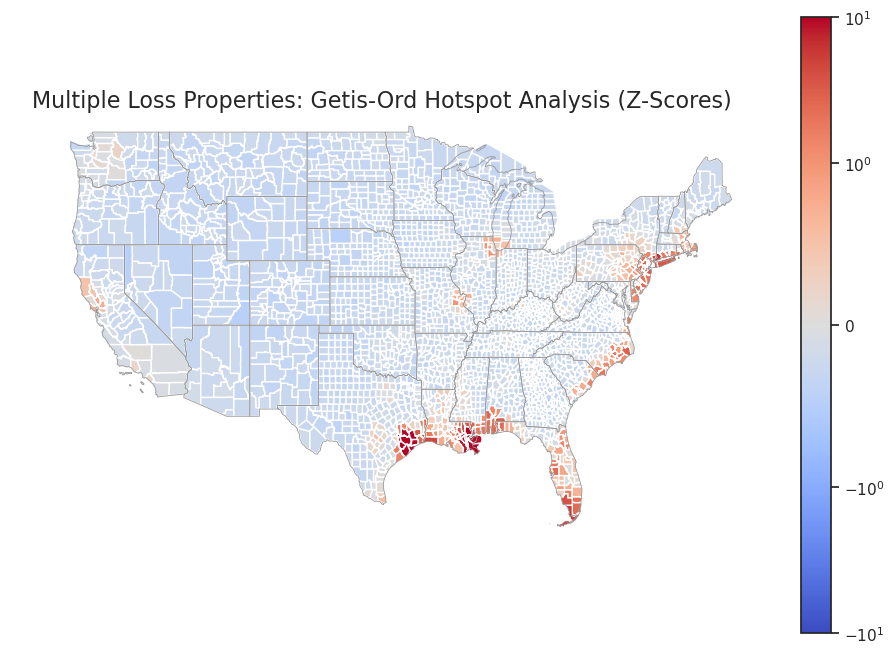

In [36]:
# Plot Z-Scores
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_totalMultiLossProp', cmap='coolwarm', norm=norm, legend=True, ax=ax)
# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor='0.6', linewidth=0.6)
ax.set_title('Multiple Loss Properties: Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')
plt.show()

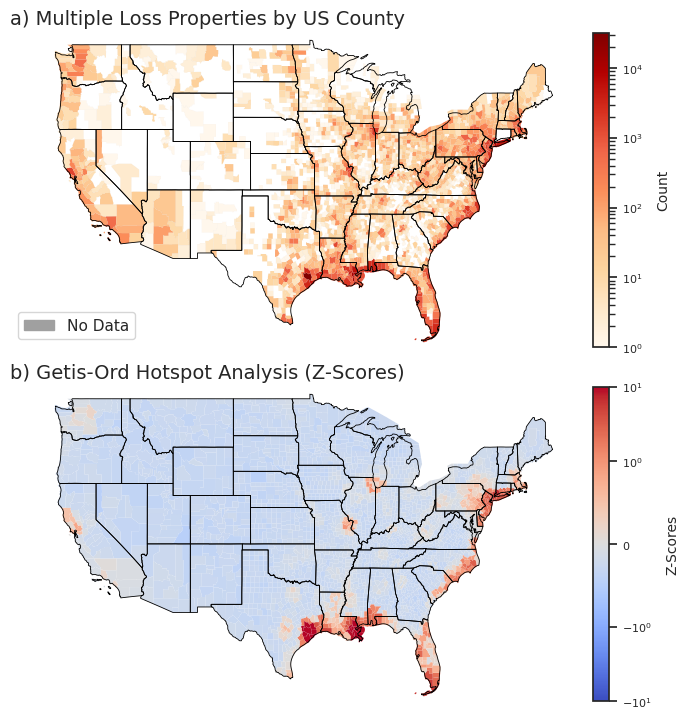

In [37]:
# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Define color palettes and normalization for the plots
cmap_orange = plt.cm.OrRd
log_norm = LogNorm(vmin=gdf_counties['totalMultiLossProp'].min() + 1, vmax=gdf_counties['totalMultiLossProp'].max())
norm_coolwarm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(7.08, 7.08), constrained_layout=True)

# Plot a) Multiple Loss Properties by US County
no_data_color = '#a0a0a0'  # Darker gray for NA values
axes[0].set_title('a) Multiple Loss Properties by US County', fontsize=14, loc='left')
no_data_mask = gdf_counties['totalMultiLossProp'] == 0
gdf_counties[no_data_mask].plot(ax=ax1, color=no_data_color, linewidth=0.01, edgecolor='0.6')
gdf_counties[~no_data_mask].plot(column='totalMultiLossProp', cmap=cmap_orange, linewidth=0.01, ax=axes[0], edgecolor='0.6', norm=log_norm)
gdf_states.boundary.plot(ax=axes[0], edgecolor='black', linewidth=0.6)
axes[0].set_xlim(extent[0], extent[1])
axes[0].set_ylim(extent[2], extent[3])
axes[0].axis('off')

# Add colorbar for the first plot
sm1 = plt.cm.ScalarMappable(cmap=cmap_orange, norm=log_norm)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=axes[0], orientation='vertical', fraction=0.03, pad=0.04)
cbar1.ax.tick_params(labelsize=8)
cbar1.set_label('Count', fontsize=10, labelpad=10)

# Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
axes[0].legend(handles=[no_data_patch], loc='lower left')

# Add a custom colorbar
sm2 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=axes[1], orientation='vertical', fraction=0.03, pad=0.04)
cbar2.set_ticks([-10, -1, 0, 1, 10])
cbar2.ax.tick_params(labelsize=8)
cbar2.set_label('Z-Scores', fontsize=10, labelpad=10)

# Plot b) Getis-Ord Hotspot Analysis (Z-Scores)
axes[1].set_title('b) Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=14, loc='left')
gdf_counties.plot(column='Z_Scores_totalMultiLossProp', linewidth=0.01, cmap='coolwarm', norm=norm_coolwarm, ax=axes[1])
gdf_states.boundary.plot(ax=axes[1], edgecolor='black', linewidth=0.6)
axes[1].set_xlim(extent[0], extent[1])
axes[1].set_ylim(extent[2], extent[3])
axes[1].axis('off')

# Show the final plot
plt.show()

In [38]:
claims_clusters = claims

# Filter claims_cluster to only include those from 1998 to present
claims_clusters['dateOfLoss'] = pd.to_datetime(claims_clusters['dateOfLoss'])

# Define cluster group
claims_clusters['Cluster_Group'] = claims_clusters[optimal_cluster].apply(lambda x: 'Unclustered' if x == -1 else 'Clustered')
claims1['Cluster_Group'] = claims1[optimal_cluster].apply(lambda x: 'Unclustered' if x == -1 else 'Clustered')

# Group by 'optimal_cluster' and calculate medians and sizes
cluster_centers = claims_clusters.groupby(optimal_cluster).agg(
    median_latitude=('latitude', 'median'),
    median_longitude=('longitude', 'median'),
    cluster_size=('latitude', 'size'),  # Count rows in each cluster
    claim_sum=('adjustedClaim', 'sum'), # Median of the claim_sum for color mapping
    median_date=("dateOfLoss", "median") 
).reset_index()

In [39]:
sum_unclustered = claims_clusters[claims_clusters[optimal_cluster] == -1]['adjustedClaim'].sum()
annual_unclustered = float(sum_unclustered)/(claims_clusters['yearOfLoss'].max()-claims_clusters['yearOfLoss'].min())
claim_sum = cluster_centers['claim_sum'].sum()
average_claim_sum = float(claim_sum)/(claims_clusters['yearOfLoss'].max()-claims_clusters['yearOfLoss'].min())

# Data for the first chart
data1 = {
    "Type": ["Unclustered", "Clustered"],
    "Value": [annual_unclustered/1000000, average_claim_sum/1000000]
}
df1 = pd.DataFrame(data1)

/tmp/ipykernel_820/319952586.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 1], data=df1, x="Type", y="Value", palette="Blues")
/tmp/ipykernel_820/319952586.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), fontsize=8)
/tmp/ipykernel_820/319952586.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


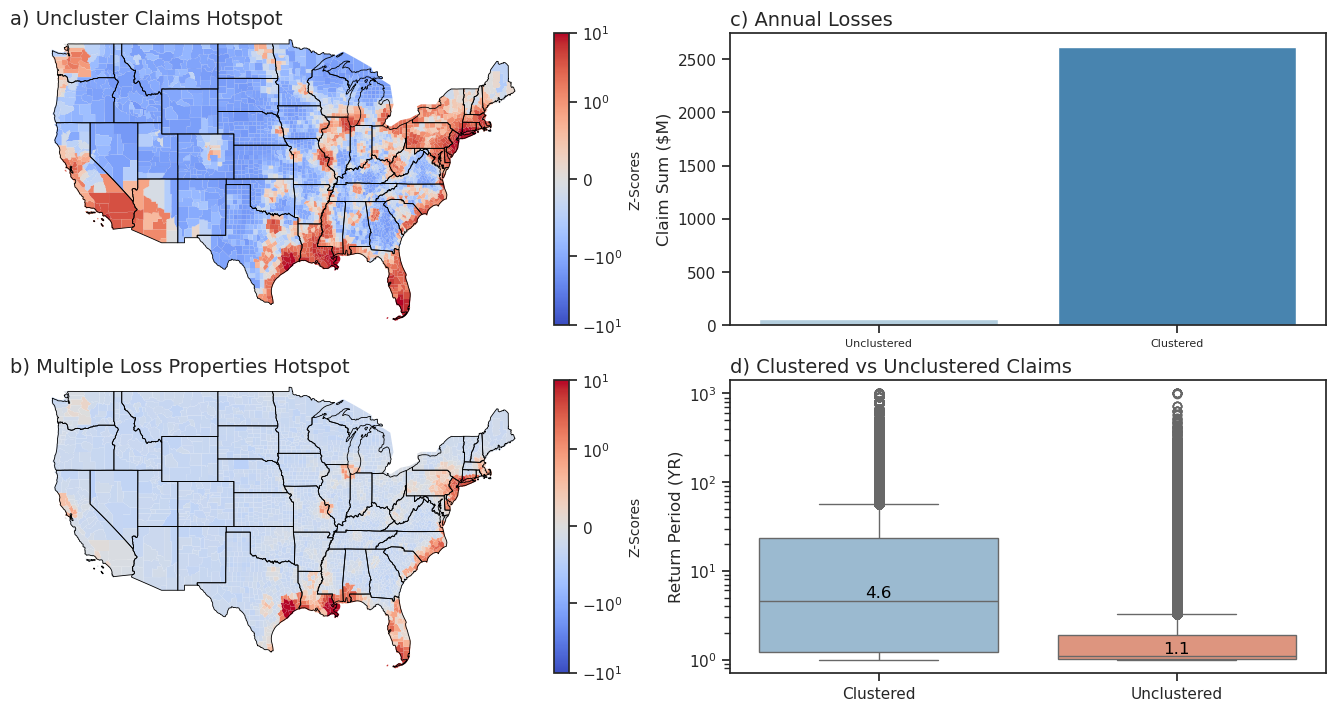

In [40]:
# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
norm_coolwarm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)

# Create the figure and a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 7), constrained_layout=True)

# Subplot a: Multiple Loss Properties by US County
axes[0, 0].set_title('a) Uncluster Claims Hotspot', fontsize=14, loc='left')
#no_data_mask = gdf_counties['Z_Scores_countUncluster'] == 0
#no_data_color = '#a0a0a0'  # Darker gray for NA values
gdf_counties.plot(
    column='Z_Scores_countUncluster', cmap='coolwarm', linewidth=0.01, ax=axes[0, 0],
    edgecolor='0.6', norm=norm_coolwarm)
gdf_states.boundary.plot(ax=axes[0, 0], edgecolor='black', linewidth=0.6)
axes[0, 0].set_xlim(extent[0], extent[1])
axes[0, 0].set_ylim(extent[2], extent[3])
axes[0, 0].axis('off')

# Add colorbar for subplot a
sm1 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_coolwarm)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=axes[0, 0], orientation='vertical', fraction=0.03, pad=0.04)
cbar1.set_label('Z-Scores', fontsize=10)

# Subplot b: Getis-Ord Hotspot Analysis (Z-Scores)
axes[1, 0].set_title('b) Multiple Loss Properties Hotspot', fontsize=14, loc='left')
norm_coolwarm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(
    column='Z_Scores_totalMultiLossProp', linewidth=0.01, cmap='coolwarm', norm=norm_coolwarm, ax=axes[1, 0]
)
gdf_states.boundary.plot(ax=axes[1, 0], edgecolor='black', linewidth=0.6)
axes[1, 0].set_xlim(extent[0], extent[1])
axes[1, 0].set_ylim(extent[2], extent[3])
axes[1, 0].axis('off')

# Add colorbar for subplot b
sm2 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_coolwarm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=axes[1, 0], orientation='vertical', fraction=0.03, pad=0.04)
cbar2.set_label('Z-Scores', fontsize=10)

# Subplot c: Annual Losses (Bar plot)
sns.barplot(ax=axes[0, 1], data=df1, x="Type", y="Value", palette="Blues")
axes[0, 1].set_title("c) Annual Losses", fontsize=14, loc='left')
axes[0, 1].set_ylabel("Claim Sum ($M)")
axes[0, 1].set_xlabel("")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), fontsize=8)

# Subplot d: Clustered vs Unclustered (Box plot)
sns.boxplot(
    ax=axes[1, 1],
    x='Cluster_Group',
    y=var,
    data=claims1,
    order=['Clustered', 'Unclustered'],
    palette=["#92BCD9", "#ED8D6F"]
)
axes[1, 1].set_title("d) Clustered vs Unclustered Claims", fontsize=14, loc='left')
axes[1, 1].set_ylabel("Return Period (YR)")
axes[1, 1].set_xlabel("")
axes[1, 1].set_yscale('log')

# Add median annotations to subplot d
medians_clustered = claims1.groupby('Cluster_Group')[var].median()
for i, group in enumerate(['Clustered', 'Unclustered']):
    median = medians_clustered.get(group, None)
    if median is not None:
        axes[1, 1].text(i, median, f'{median:.1f}', ha='center', va='bottom', color='black')

# Final adjustments and show plot
plt.show()

/tmp/ipykernel_820/120306843.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_c, data=df1, x="Type", y="Value", palette="Blues")
/tmp/ipykernel_820/120306843.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_c.set_xticklabels(ax_c.get_xticklabels(), fontsize=8)
/tmp/ipykernel_820/120306843.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_820/120306843.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_d.set_xticklabels(ax_c.get_xticklabels(), fontsize=8)


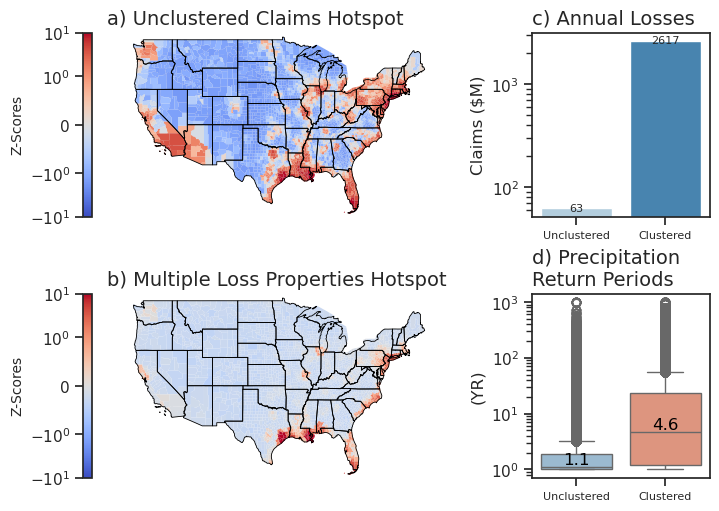

In [41]:
# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
norm_coolwarm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)

# Create the figure with GridSpec for custom column widths
fig = plt.figure(figsize=(7.08, 5), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig, width_ratios=[2, 1])  # Adjust column width ratios

# Subplot a: Uncluster Claims Hotspot
ax_a = fig.add_subplot(gs[0, 0])
ax_a.set_title('a) Unclustered Claims Hotspot', fontsize=14, loc='left')
gdf_counties.plot(
    column='Z_Scores_countUncluster', cmap='coolwarm', linewidth=0.01, ax=ax_a,
    edgecolor='0.6', norm=norm_coolwarm)
gdf_states.boundary.plot(ax=ax_a, edgecolor='black', linewidth=0.6)
ax_a.set_xlim(extent[0], extent[1])
ax_a.set_ylim(extent[2], extent[3])
ax_a.axis('off')

# Add colorbar for subplot a
sm1 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_coolwarm)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=ax_a, orientation='vertical', location='left', fraction=0.03, pad=0.04)
cbar1.set_label('Z-Scores', fontsize=10)

# Subplot b: Multiple Loss Properties Hotspot
ax_b = fig.add_subplot(gs[1, 0])
ax_b.set_title('b) Multiple Loss Properties Hotspot', fontsize=14, loc='left')
gdf_counties.plot(
    column='Z_Scores_totalMultiLossProp', linewidth=0.01, cmap='coolwarm', norm=norm_coolwarm, ax=ax_b
)
gdf_states.boundary.plot(ax=ax_b, edgecolor='black', linewidth=0.6)
ax_b.set_xlim(extent[0], extent[1])
ax_b.set_ylim(extent[2], extent[3])
ax_b.axis('off')

# Add colorbar for subplot b
sm2 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_coolwarm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax_b, orientation='vertical', location='left', fraction=0.03, pad=0.04)
cbar2.set_label('Z-Scores', fontsize=10)

# Subplot c: Annual Losses (Bar plot)
ax_c = fig.add_subplot(gs[0, 1])
sns.barplot(ax=ax_c, data=df1, x="Type", y="Value", palette="Blues")
ax_c.set_title("c) Annual Losses", fontsize=14, loc='left')
ax_c.set_ylabel("Claims ($M)")
ax_c.set_xlabel("")
ax_c.set_xticklabels(ax_c.get_xticklabels(), fontsize=8)
# Set y-axis to logarithmic scale
ax_c.set_yscale('log')

# Add labels on top of the bars
for bar in ax_c.patches:
    height = bar.get_height()  # Get the height of the bar
    y_pos = height*0.9
    if height > 0:  # Avoid labeling bars with non-positive heights
        ax_c.text(
            bar.get_x() + bar.get_width() / 2,  # X position of the label
            y_pos,  # Y position of the label
            f'{height:.0f}',  # Rounded value as a string
            ha='center',  # Center align the text
            va='bottom',  # Bottom align the text
            fontsize=8  # Adjust font size
        )

# Subplot d: Clustered vs Unclustered (Box plot)
ax_d = fig.add_subplot(gs[1, 1])
sns.boxplot(
    ax=ax_d,
    x='Cluster_Group',
    y=var,
    data=claims1,
    order=['Unclustered','Clustered'],
    palette=["#92BCD9", "#ED8D6F"]
)
ax_d.set_title("d) Precipitation\nReturn Periods", fontsize=14, loc='left')
ax_d.set_ylabel("(YR)")
ax_d.set_xlabel("")
ax_d.set_yscale('log')
ax_d.set_xticklabels(ax_c.get_xticklabels(), fontsize=8)


# Add median annotations to subplot d
medians_clustered = claims1.groupby('Cluster_Group')[var].median()
for i, group in enumerate(['Unclustered','Clustered']):
    median = medians_clustered.get(group, None)
    if median is not None:
        ax_d.text(i, median, f'{median:.1f}', ha='center', va='bottom', color='black')

if save:
    output_path = 'Plots/F4_Unclustered_Hotspot.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Final adjustments and show plot
plt.show()

## Disaster Declarations 

In [42]:
final_disasters_df = pd.read_csv("../2_Low_Return_Period/no_percentile_filter/final_filtered_disasters.csv")
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].astype(int).astype(str)
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].apply(lambda x: str(x).zfill(5))

# Read the two CSV files
owners_df = pd.read_csv("../2_Low_Return_Period/no_percentile_filter/final_filtered_aid_owners.csv")
renters_df = pd.read_csv("../2_Low_Return_Period/no_percentile_filter/final_filtered_aid_renters.csv")

# Concatenate the dataframes
filtered_aid_df = pd.concat([owners_df, renters_df], ignore_index=True)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].astype(int).astype(str)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].apply(lambda x: str(x).zfill(5))
filtered_aid_df = filtered_aid_df.groupby(["disasterNumber","fullFIPS"]).agg({'approvedForFemaAssistance': 'sum' }).reset_index()

final_disasters_df = final_disasters_df.merge(filtered_aid_df[["disasterNumber","fullFIPS",'approvedForFemaAssistance']], how="left", on=["disasterNumber","fullFIPS"])

In [43]:
# Replace NaNs with 0 and ensure all values are non-negative integers
final_disasters_df['approvedForFemaAssistance'] = pd.to_numeric(
    final_disasters_df['approvedForFemaAssistance'], errors='coerce'
).fillna(0).clip(lower=0).astype(int)

# Ensure the column is an integer (it should represent the number of repetitions)
final_disasters_df = final_disasters_df.loc[final_disasters_df.index.repeat(final_disasters_df['approvedForFemaAssistance'])]

In [44]:
# Ensure fullFIPS has leading zeros (5 characters)
final_disasters_df['fullFIPS'] = final_disasters_df['fullFIPS'].astype(int).astype(str).str.zfill(5)

count_by_fips_df = final_disasters_df.groupby('fullFIPS').size().reset_index(name='disasterCount')

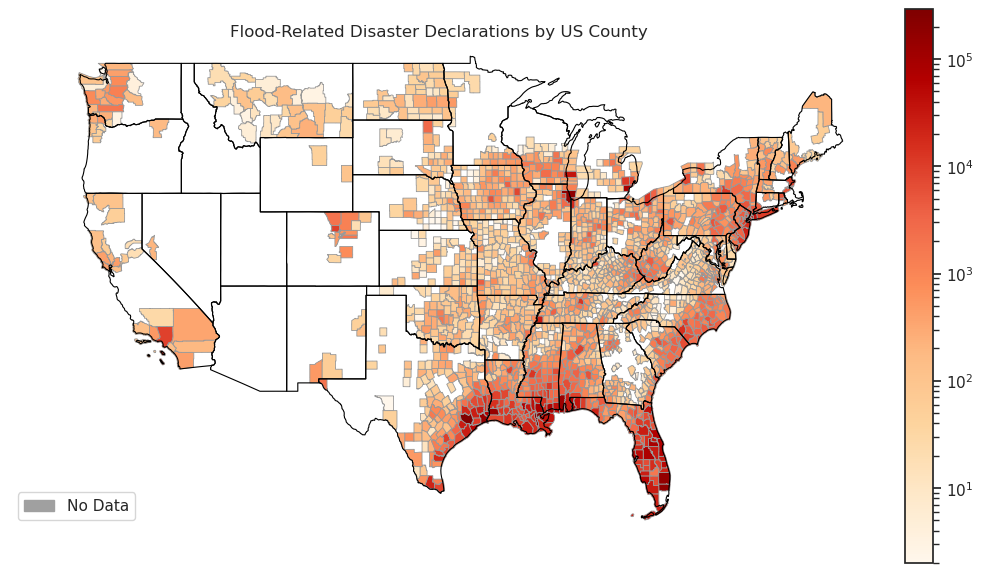

In [45]:
# Load the shapefile for US counties
#shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
#gdf_counties = gpd.read_file(shapefile_path)

# Merge the aggregated data with the shapefile
gdf_counties = gdf_counties.merge(count_by_fips_df, left_on='GEOID', right_on='fullFIPS', how='left', suffixes=('', '_drop'))

# Step 4: Drop the duplicate 'countyCode_drop' column from the merge
gdf_counties.drop(columns=['fullFIPS_drop'], inplace=True, errors='ignore')

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Change the color palette to OrRd for non-negative values
cmap = plt.cm.OrRd

# Set vmin and vmax based on the range of your data
vmin = gdf_counties['disasterCount'].min()+1
vmax = gdf_counties['disasterCount'].max()

# Apply LogNorm for a logarithmic scale
log_norm = LogNorm(vmin=vmin, vmax=vmax)

# Plot the data
fig, axes = plt.subplots(1, 1, figsize=(10, 8))  # Adjusted figure size

# Plot counties with data
gdf_counties[~gdf_counties['disasterCount'].isna()].plot(column='disasterCount', cmap=cmap, linewidth=0.6, ax=axes, edgecolor='0.6', norm=log_norm)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=axes, edgecolor='black', linewidth=0.8)

# Add title and extent
axes.set_title('Flood-Related Disaster Declarations by US County')
axes.set_xlim(extent[0], extent[1])
axes.set_ylim(extent[2], extent[3])
axes.axis('off')

# Define the colorbar with the OrRd colormap and logarithmic norm
sm = plt.cm.ScalarMappable(cmap=cmap, norm=log_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.04)  

# Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
axes.legend(handles=[no_data_patch], loc='lower left')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot with 500 dpi
#output_path = 'multiple_loss_prop.png'
#plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

In [46]:
# Define spatial weights
w = Queen.from_dataframe(gdf_counties)
w.transform = 'r'  # Row-standardized weights

# Handle missing values (replace with 0 if necessary)
gdf_counties['disasterCount'] = gdf_counties['disasterCount'].fillna(0)

# Perform Getis-Ord analysis
attribute = gdf_counties['disasterCount'].values
g_local = G_Local(attribute, w)

# Add results to GeoDataFrame
gdf_counties['G_Statistic_disasterCount'] = g_local.Gs
gdf_counties['Z_Scores_disasterCount'] = g_local.z_sim
gdf_counties['P_Values_disasterCount'] = g_local.p_sim

/tmp/ipykernel_820/1503379449.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_counties)


('WARNING: ', 365, ' is an island (no neighbors)')
('WARNING: ', 800, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 964, ' is an island (no neighbors)')
('WARNING: ', 1248, ' is an island (no neighbors)')
('WARNING: ', 1926, ' is an island (no neighbors)')
('WARNING: ', 2082, ' is an island (no neighbors)')
('WARNING: ', 2736, ' is an island (no neighbors)')
('WARNING: ', 3102, ' is an island (no neighbors)')
('WARNING: ', 3209, ' is an island (no neighbors)')


/srv/conda/envs/notebook/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
 There are 10 islands with ids: 365, 800, 891, 964, 1248, 1926, 2082, 2736, 3102, 3209.
  W.__init__(self, neighbors, ids=ids, **kw)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


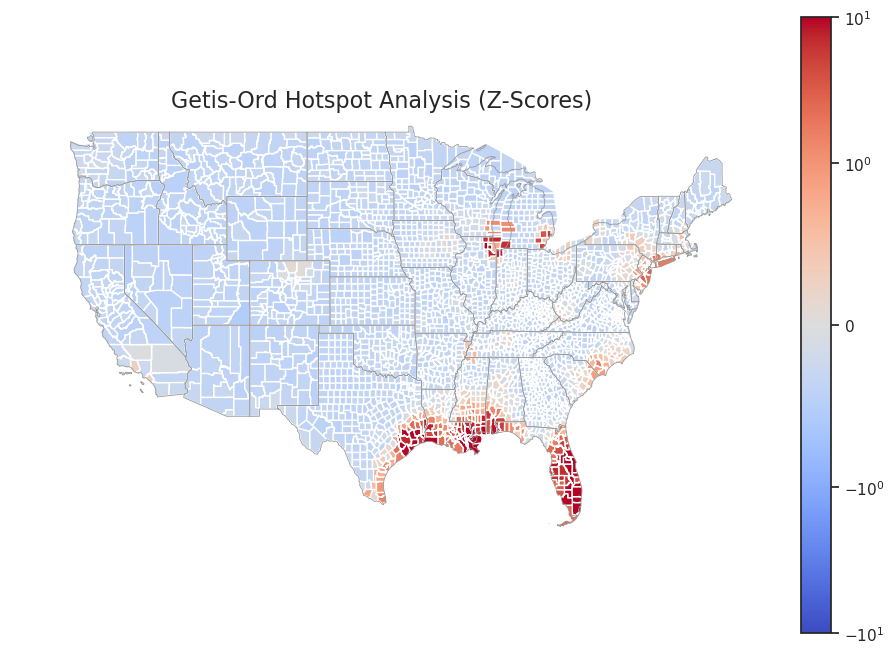

In [47]:
# Plot Z-Scores
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_disasterCount', cmap='coolwarm', norm=norm, legend=True, ax=ax)
# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor='0.6', linewidth=0.6)
ax.set_title('Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')
plt.show()

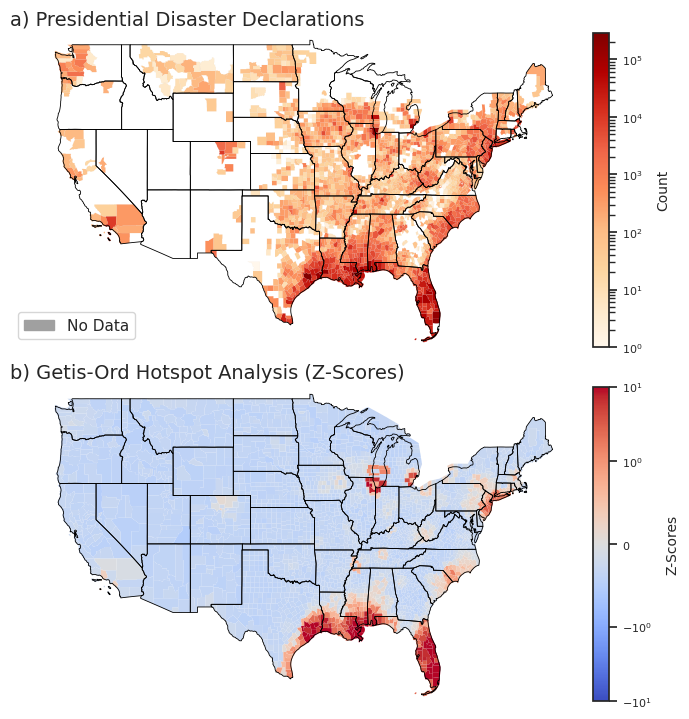

In [48]:
# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Define color palettes and normalization for the plots
cmap_orange = plt.cm.OrRd
log_norm = LogNorm(vmin=gdf_counties['disasterCount'].min() + 1, vmax=gdf_counties['disasterCount'].max())
norm_coolwarm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(7.08, 7.08), constrained_layout=True)

# Plot a) Multiple Loss Properties by US County
no_data_color = '#a0a0a0'  # Darker gray for NA values
axes[0].set_title('a) Presidential Disaster Declarations', fontsize=14, loc='left')
no_data_mask = gdf_counties['disasterCount'] == 0
gdf_counties[no_data_mask].plot(ax=ax1, color=no_data_color, linewidth=0.01, edgecolor='0.6')
gdf_counties[~no_data_mask].plot(column='disasterCount', cmap=cmap_orange, linewidth=0.01, ax=axes[0], edgecolor='0.6', norm=log_norm)
gdf_states.boundary.plot(ax=axes[0], edgecolor='black', linewidth=0.6)
axes[0].set_xlim(extent[0], extent[1])
axes[0].set_ylim(extent[2], extent[3])
axes[0].axis('off')

# Add colorbar for the first plot
sm1 = plt.cm.ScalarMappable(cmap=cmap_orange, norm=log_norm)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=axes[0], orientation='vertical', fraction=0.03, pad=0.04)
cbar1.ax.tick_params(labelsize=8)
cbar1.set_label('Count', fontsize=10, labelpad=10)

# Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
axes[0].legend(handles=[no_data_patch], loc='lower left')

# Add a custom colorbar
sm2 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=axes[1], orientation='vertical', fraction=0.03, pad=0.04)
cbar2.set_ticks([-10, -1, 0, 1, 10])
cbar2.ax.tick_params(labelsize=8)
cbar2.set_label('Z-Scores', fontsize=10, labelpad=10)

# Plot b) Getis-Ord Hotspot Analysis (Z-Scores)
axes[1].set_title('b) Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=14, loc='left')
gdf_counties.plot(column='Z_Scores_disasterCount', linewidth=0.01, cmap='coolwarm', norm=norm_coolwarm, ax=axes[1])
gdf_states.boundary.plot(ax=axes[1], edgecolor='black', linewidth=0.6)
axes[1].set_xlim(extent[0], extent[1])
axes[1].set_ylim(extent[2], extent[3])
axes[1].axis('off')

# Show the final plot
plt.show()

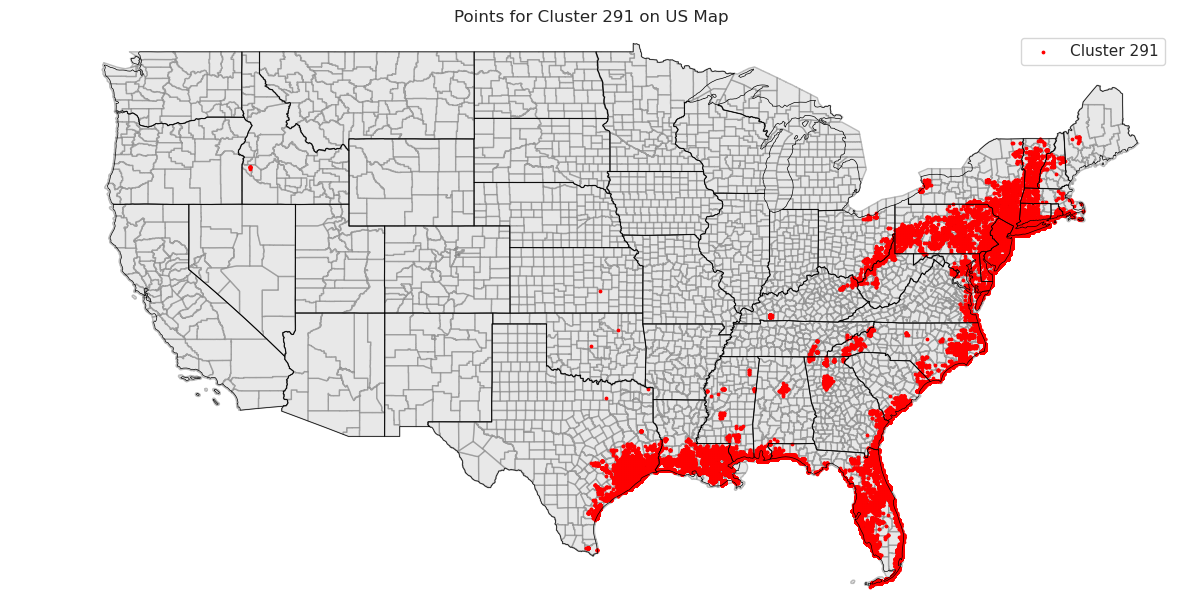

In [49]:
# Top 10: 4, 76, 277, 8, 248, 6, 263, 78, 125, 291

claim_num = 291

extent=[-130, -65, 24, 50]

# Filter for points in the specified cluster
cluster_points = claims[claims[optimal_cluster] == claim_num] #178, 4193, 1923, 1276
cluster_points = billion_dollar_claims

# 1388, 1272, 1201, 1007

# Create a GeoDataFrame for the points
gdf_claims_all = gpd.GeoDataFrame(
    cluster_points,
    geometry=gpd.points_from_xy(cluster_points['longitude'], cluster_points['latitude']),
    crs="EPSG:4326"
)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot counties and states
gdf_counties.plot(ax=ax, color='lightgray', edgecolor='gray', alpha=0.5)
gdf_states.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot the cluster points
gdf_claims_all.plot(ax=ax, color='red', markersize=3, label=f'Cluster {claim_num}')

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')

# Add legend and labels
plt.legend()
plt.title(f"Points for Cluster {claim_num} on US Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [50]:
# Group by 'optimal_cluster' and calculate medians and sizes
cluster_centers_hyper = billion_dollar_claims.groupby(optimal_cluster).agg(
    median_latitude=('latitude', 'median'),
    median_longitude=('longitude', 'median'),
    cluster_size=('latitude', 'size'),  # Count rows in each cluster
    claim_sum=('adjustedClaim', 'sum'), # Median of the claim_sum for color mapping
    median_date=("dateOfLoss", "median") 
).reset_index()

average_hyperclustered = cluster_centers_hyper['claim_sum'].mean()
annual_hyperclustered = float(sum_unclustered)/(claims_clusters['yearOfLoss'].max()-claims_clusters['yearOfLoss'].min())
average_claim_sum = cluster_centers['claim_sum'].mean()

# Data for the first chart
data1 = {
    "Type": ["Clustered","Hyperclustered"],
    "Value": [average_claim_sum/1000000,average_hyperclustered/1000000]
}
df1 = pd.DataFrame(data1)

/tmp/ipykernel_820/3088872.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax_c, data=df1, x="Type", y="Value", palette="Blues")
/tmp/ipykernel_820/3088872.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_c.set_xticklabels(ax_c.get_xticklabels(), fontsize=8)
/tmp/ipykernel_820/3088872.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billion_dollar_claims1['Dataset'] = 'Hyperclustered'
/tmp/ipykernel_820/3088872.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

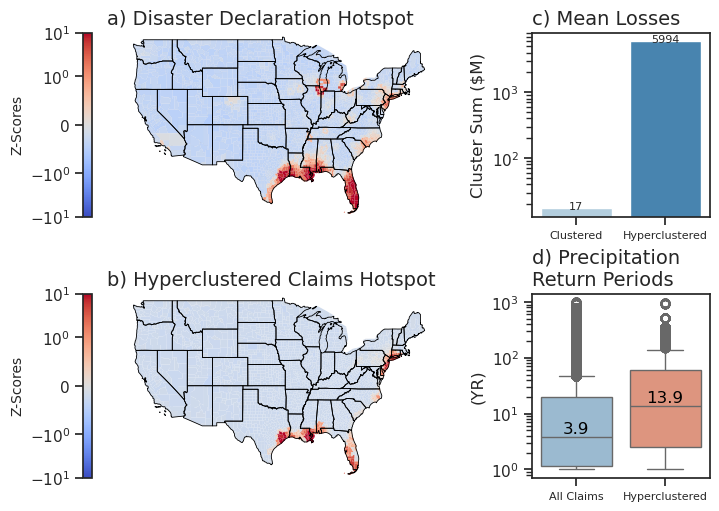

In [51]:
# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
norm_coolwarm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)

# Create the figure with GridSpec for custom column widths
fig = plt.figure(figsize=(7.08, 5), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig, width_ratios=[2, 1])  # Adjust column width ratios

# Subplot a: Uncluster Claims Hotspot
ax_a = fig.add_subplot(gs[0, 0])
ax_a.set_title('a) Disaster Declaration Hotspot', fontsize=14, loc='left')
gdf_counties.plot(
    column='Z_Scores_disasterCount', cmap='coolwarm', linewidth=0.01, ax=ax_a,
    edgecolor='0.6', norm=norm_coolwarm)
gdf_states.boundary.plot(ax=ax_a, edgecolor='black', linewidth=0.6)
ax_a.set_xlim(extent[0], extent[1])
ax_a.set_ylim(extent[2], extent[3])
ax_a.axis('off')

# Add colorbar for subplot a
sm1 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_coolwarm)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=ax_a, orientation='vertical', location='left', fraction=0.03, pad=0.04)
cbar1.set_label('Z-Scores', fontsize=10)

# Subplot b: Multiple Loss Properties Hotspot
ax_b = fig.add_subplot(gs[1, 0])
ax_b.set_title('b) Hyperclustered Claims Hotspot', fontsize=14, loc='left')
gdf_counties.plot(
    column='Z_Scores_hyperCount', linewidth=0.01, cmap='coolwarm', norm=norm_coolwarm, ax=ax_b
)
gdf_states.boundary.plot(ax=ax_b, edgecolor='black', linewidth=0.6)
ax_b.set_xlim(extent[0], extent[1])
ax_b.set_ylim(extent[2], extent[3])
ax_b.axis('off')

# Add colorbar for subplot b
sm2 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_coolwarm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax_b, orientation='vertical', location='left', fraction=0.03, pad=0.04)
cbar2.set_label('Z-Scores', fontsize=10)

# Subplot c: Annual Losses (Bar plot)
ax_c = fig.add_subplot(gs[0, 1])
sns.barplot(ax=ax_c, data=df1, x="Type", y="Value", palette="Blues")
ax_c.set_title("c) Mean Losses", fontsize=14, loc='left')
ax_c.set_ylabel("Cluster Sum ($M)")
ax_c.set_xlabel("")
ax_c.set_xticklabels(ax_c.get_xticklabels(), fontsize=8)
# Set y-axis to logarithmic scale
ax_c.set_yscale('log')

# Add labels on top of the bars
for bar in ax_c.patches:
    height = bar.get_height()  # Get the height of the bar
    y_pos = height*0.9
    if height > 0:  # Avoid labeling bars with non-positive heights
        ax_c.text(
            bar.get_x() + bar.get_width() / 2,  # X position of the label
            y_pos,  # Y position of the label
            f'{height:.0f}',  # Rounded value as a string
            ha='center',  # Center align the text
            va='bottom',  # Bottom align the text
            fontsize=8  # Adjust font size
        )

# Subplot d: Hyperclustered vs All (Box plot)
ax_d = fig.add_subplot(gs[1, 1])

# Add a new column to distinguish the datasets
claims1['Dataset'] = 'All Claims'
billion_dollar_claims1['Dataset'] = 'Hyperclustered'

# Combine the datasets for comparison
combined_data = pd.concat([claims1, billion_dollar_claims1], ignore_index=True)

sns.boxplot(
    ax=ax_d,
    x='Dataset',
    y=var,
    data=combined_data,
    order=['All Claims', 'Hyperclustered'],
    palette=["#92BCD9", "#ED8D6F"]
)
ax_d.set_title("d) Precipitation\nReturn Periods", fontsize=14, loc='left')
ax_d.set_ylabel("(YR)")
ax_d.set_xlabel("")
ax_d.set_yscale('log')
ax_d.tick_params(axis='x', labelsize=8)

# Add median annotations to subplot d
medians_clustered = combined_data.groupby('Dataset')[var].median()
for i, group in enumerate(['All Claims','Hyperclustered']):
    median = medians_clustered.get(group, None)
    if median is not None:
        ax_d.text(i, median, f'{median:.1f}', ha='center', va='bottom', color='black')

if save:
    output_path = 'Plots/F5_Hypercluster_Hotspot.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Final adjustments and show plot
plt.show()

# Game Theory Weights

/tmp/ipykernel_820/1296452251.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)


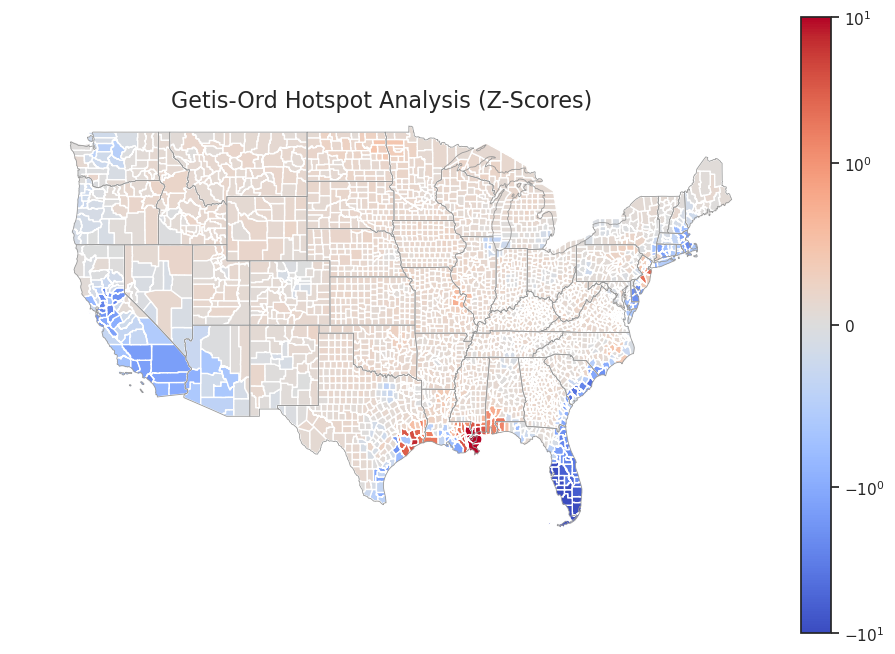

In [52]:
gdf_counties["Z_Scores_meanLoss"]=-1*gdf_counties["Z_Scores_meanLoss"]

# Plot Z-Scores
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
cmap = plt.cm.get_cmap('coolwarm')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_meanLoss', norm=norm, cmap=cmap, legend=True, ax=ax)
# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor='0.6', linewidth=0.6)
ax.set_title('Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')
plt.show()

In [53]:
# Replace missing values in 'meanLoss' with 0
gdf_counties['lossOnly'] = gdf_counties['meanLoss'].fillna(0)

# Set 'meanLoss' values that are greater than or equal to 0 to 0
gdf_counties.loc[gdf_counties['lossOnly'] >= 0, 'lossOnly'] = 0
gdf_counties['lossOnly']=gdf_counties['lossOnly']*-1

In [54]:
# Define spatial weights
w = Queen.from_dataframe(gdf_counties)
w.transform = 'r'  # Row-standardized weights

# Perform Getis-Ord analysis
attribute = gdf_counties['lossOnly'].values
g_local = G_Local(attribute, w)

# Add results to GeoDataFrame
gdf_counties['G_Statistic_lossOnly'] = g_local.Gs
gdf_counties['Z_Scores_lossOnly'] = g_local.z_sim
gdf_counties['P_Values_lossOnly'] = g_local.p_sim

/tmp/ipykernel_820/3144000269.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_counties)


('WARNING: ', 365, ' is an island (no neighbors)')
('WARNING: ', 800, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 964, ' is an island (no neighbors)')
('WARNING: ', 1248, ' is an island (no neighbors)')
('WARNING: ', 1926, ' is an island (no neighbors)')
('WARNING: ', 2082, ' is an island (no neighbors)')
('WARNING: ', 2736, ' is an island (no neighbors)')
('WARNING: ', 3102, ' is an island (no neighbors)')
('WARNING: ', 3209, ' is an island (no neighbors)')


/srv/conda/envs/notebook/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
 There are 10 islands with ids: 365, 800, 891, 964, 1248, 1926, 2082, 2736, 3102, 3209.
  W.__init__(self, neighbors, ids=ids, **kw)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/srv/conda/envs/notebook/lib/python3.12/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


/tmp/ipykernel_820/2359503888.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)


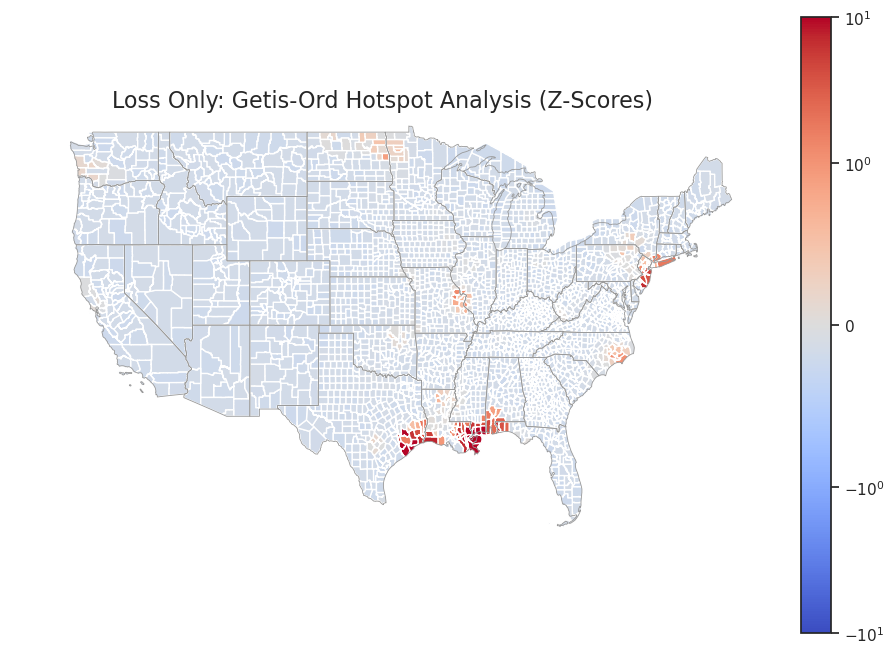

In [55]:
# Plot Z-Scores
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
cmap = plt.cm.get_cmap('coolwarm')  # Reverse of 'coolwarm' (equivalent to 'warmcool' inverted)
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_lossOnly', norm=norm, cmap=cmap, legend=True, ax=ax)
# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor='0.6', linewidth=0.6)
ax.set_title('Loss Only: Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')
plt.show()

# Calculate Objective Weights

In [56]:
# Define a log transformation function
def log_transform(data):
    epsilon = 1e-9  # Avoid log(0)
    return np.log1p(data + epsilon)

# Step 1: Apply log transformation
metrics = ["lossOnly", "hyperCount", "disasterCount", "totalMultiLossProp", "countUncluster"]

for metric in metrics:
    gdf_counties[f"log_{metric}"] = log_transform(gdf_counties[metric])

# Step 2: Calculate entropy on log-transformed values
log_metrics = [f"log_{metric}" for metric in metrics]
data_matrix = gdf_counties[log_metrics].values  # Use log-transformed values directly

# Normalize each column to sum to 1 (row-wise probability distribution)
normalized_matrix = data_matrix / data_matrix.sum(axis=0, keepdims=True)

# Calculate entropy
epsilon = 1e-9  # Small value to avoid log(0)
log_matrix = np.log(normalized_matrix + epsilon)
entropy = -np.nansum(normalized_matrix * log_matrix, axis=0) / np.log(data_matrix.shape[0])

# Step 3: Calculate diversity (1 - entropy)
diversity = 1 - entropy

# Step 4: Normalize diversity to calculate objective weights (OW)
OW = diversity / diversity.sum()

# Step 5: Standardize metrics after entropy calculation

# Use the standardized metrics (norm_{metric})
log_metrics = [f"log_{metric}" for metric in metrics]  # Ensure these are standardized

scaler = MinMaxScaler()
for metric in log_metrics:
    gdf_counties[f"norm_{metric}"] = scaler.fit_transform(gdf_counties[[metric]])

print("Updated Objective Weights (OW):", OW)

Updated Objective Weights (OW): [0.33532814 0.41568067 0.10657004 0.10025927 0.04216188]


# Calculate Subjective Weights

In [57]:
# Step 2: Calculate Subjective Weight (SW) using AHP
# Updated pairwise matrix based on the priority ranking
pairwise_matrix = np.array([
    [1, 2, 3, 4, 5],  # `meanLoss` compared to others
    [1/2, 1, 2, 3, 4],  # `hyperCount` compared to others
    [1/3, 1/2, 1, 2, 3],  # `disasterCount` compared to others
    [1/4, 1/3, 1/2, 1, 2],  # `totalMultiLossProp` compared to others
    [1/5, 1/4, 1/3, 1/2, 1],  # `countUncluster` compared to others
])

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(pairwise_matrix)
max_eigenvalue = np.max(eigenvalues)
SW = eigenvectors[:, np.argmax(eigenvalues)].real
SW = SW / SW.sum()  # Normalize weights

# Consistency check
n = pairwise_matrix.shape[0]
CI = (max_eigenvalue - n) / (n - 1)
RI_dict = {1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12}  # Example RI values from Saaty 1980
RI = RI_dict[n]
CR = CI / RI
assert CR < 0.1, f"Consistency Ratio (CR = {CR}) is too high, re-evaluate pairwise matrix"

print("Updated Subjective Weights (SW):", SW)

Updated Subjective Weights (SW): [0.41853929 0.26251761 0.15992286 0.09725359 0.06176665]


# Combine Weights

In [58]:
# Step 4: Combine SW and OW into Combination Weight (CW) using GT
weights_matrix = np.vstack((SW, OW))
alpha = np.linalg.solve(weights_matrix @ weights_matrix.T, weights_matrix.sum(axis=1))
CW = (weights_matrix.T @ alpha).flatten()

print("Updated Combination Weights (CW):", CW)

Updated Combination Weights (CW): [1.44617231 0.99508388 0.54333966 0.3456137  0.21028211]


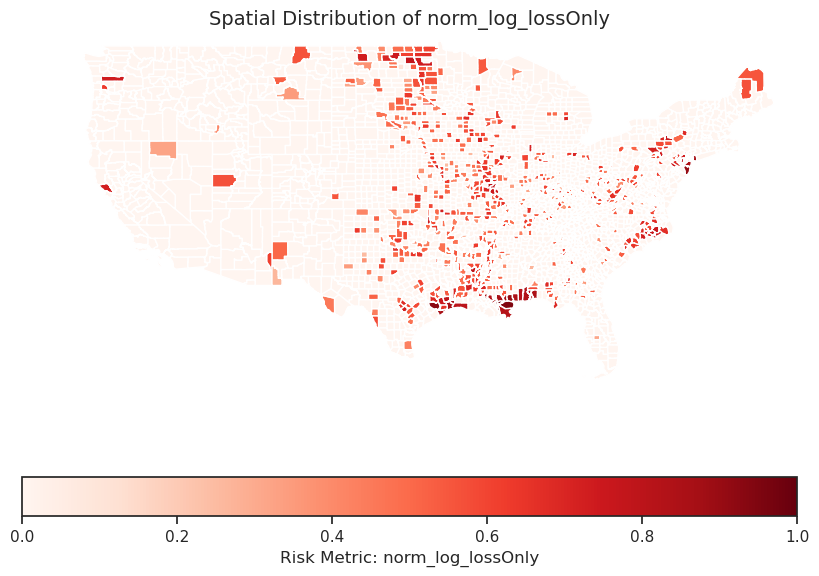

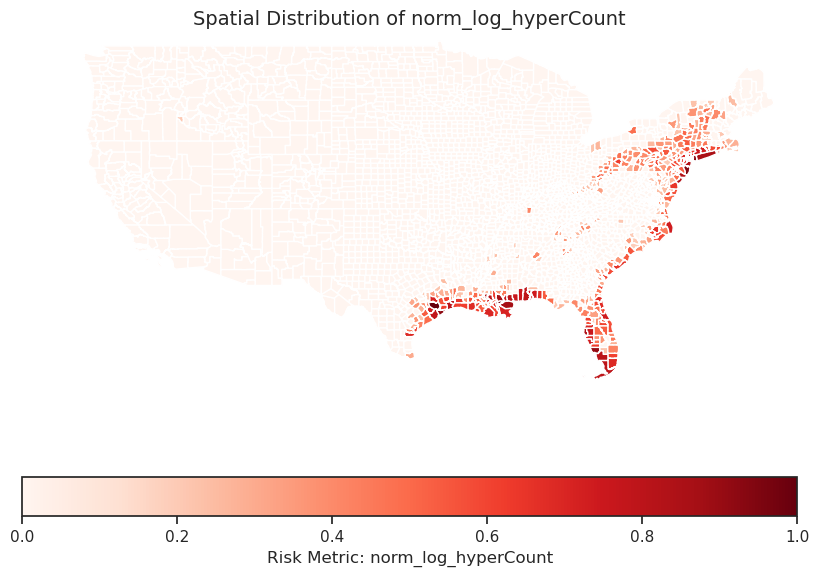

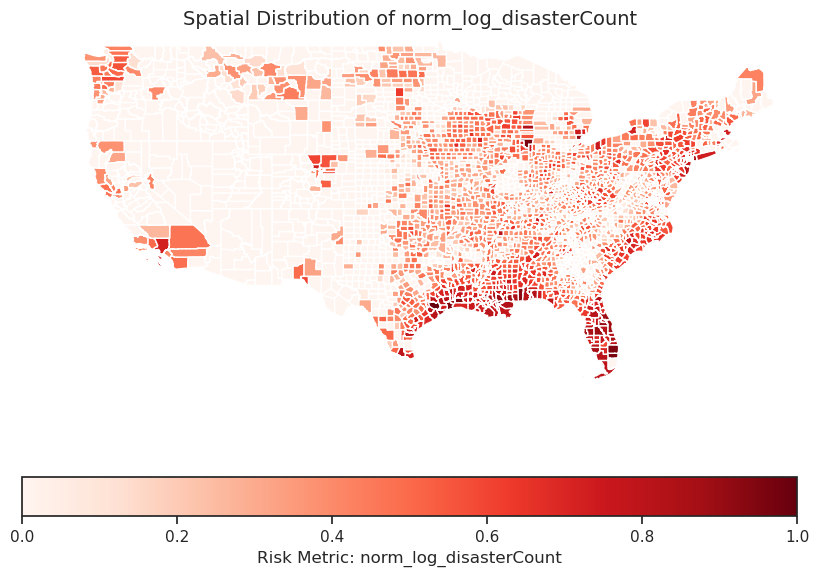

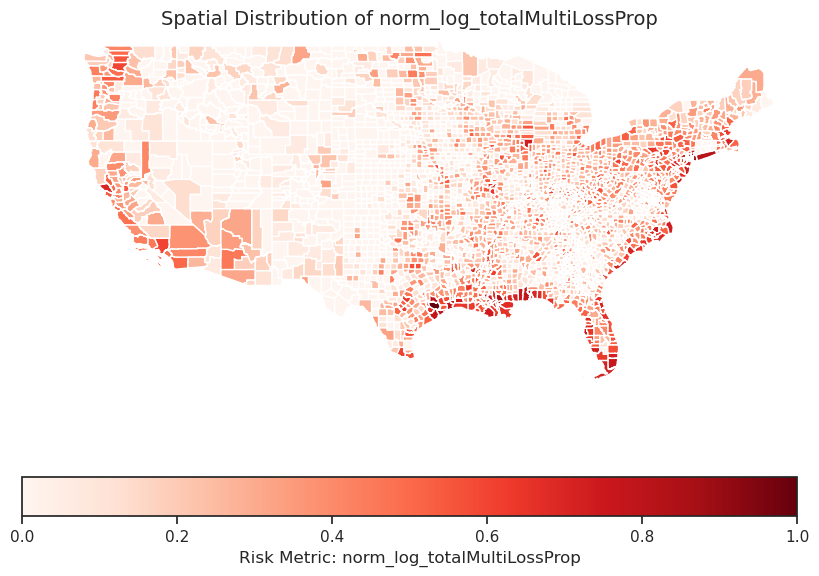

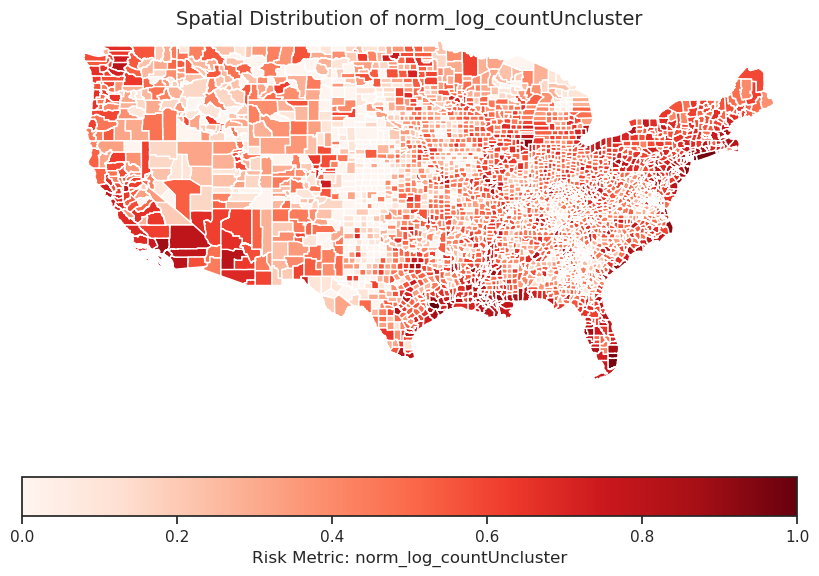

In [59]:
# Use the standardized metrics (norm_{metric})
standardized_metrics = [f"norm_{metric}" for metric in log_metrics]  # Ensure these are standardized

# Create a map for each metric
for metric in standardized_metrics:
    # Plot the metric
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_counties.plot(
        column=metric, 
        cmap="Reds",  # Adjust the colormap if needed
        legend=True, 
        legend_kwds={'label': f"Risk Metric: {metric}", 'orientation': "horizontal"},
        ax=ax
    )
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_title(f"Spatial Distribution of {metric}", fontsize=14)
    ax.axis("off")
    plt.show()

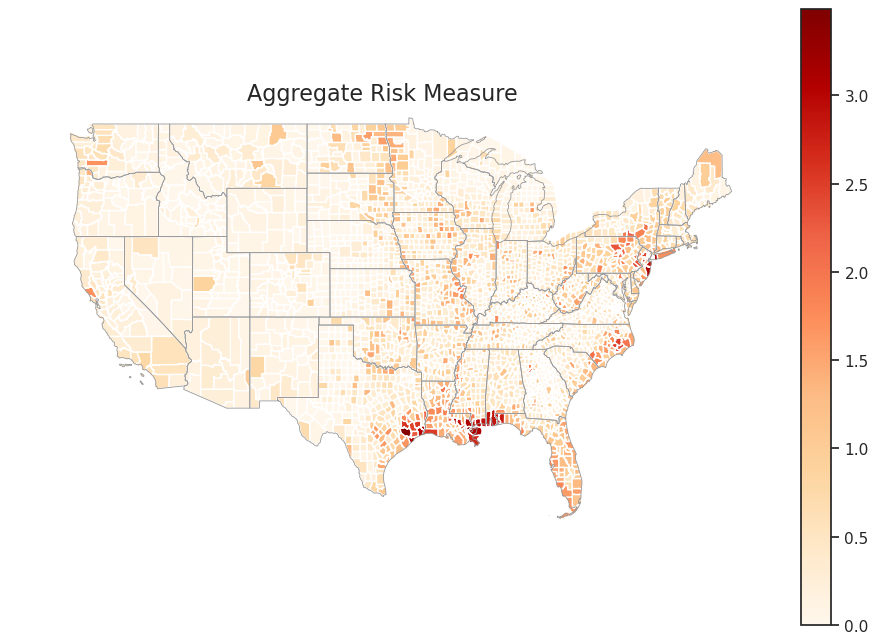

In [60]:
# Step 5: Aggregate Risk Scores with CW
risk_scores = gdf_counties[standardized_metrics].values @ CW  # Weighted sum of standardized metrics
gdf_counties['Risk_Score'] = risk_scores.flatten()

# Plot Risk Scores
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
# Change the color palette to OrRd for non-negative values
cmap = plt.cm.OrRd
#norm = SymLogNorm(linthresh=0.1, vmin=gdf_counties['Risk_Level'].min(), vmax=gdf_counties['Risk_Level'].max(), base=10)
gdf_counties.plot(column='Risk_Score', cmap=cmap, legend=True, ax=ax)
# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor='0.6', linewidth=0.6)
ax.set_title('Aggregate Risk Measure', fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis('off')

plt.show()

In [61]:
# Step 6: Determine Grading Standards using K-means
kmeans = KMeans(n_clusters=4, random_state=42)
risk_scores = risk_scores.reshape(-1, 1)  # Reshape for K-means
kmeans.fit(risk_scores)
threshold_standards = np.sort(kmeans.cluster_centers_.flatten())  # Sorted cluster centers as thresholds
print("Threshold Standards (K-means Cluster Centers):", threshold_standards)

Threshold Standards (K-means Cluster Centers): [0.12246454 0.49745166 1.20689492 2.3151536 ]


In [62]:
# Final step: Define the risk levels
risk_levels = ["lowest", "lower", "medium", "higher", "highest"]

# Ensure the grading_standards (thresholds) are sorted in ascending order
threshold_standards = np.sort(threshold_standards)

# Function to assign risk levels based on threshold bins
def assign_risk_category(score, thresholds, categories):
    bin_index = np.digitize(score, thresholds, right=True)  # Finds the appropriate bin index
    return categories[min(bin_index, len(categories) - 1)]  # Ensure it does not exceed max index

# Apply binning to the risk scores
gdf_counties["Risk_Category"] = gdf_counties["Risk_Score"].apply(lambda x: assign_risk_category(x, threshold_standards, risk_levels))

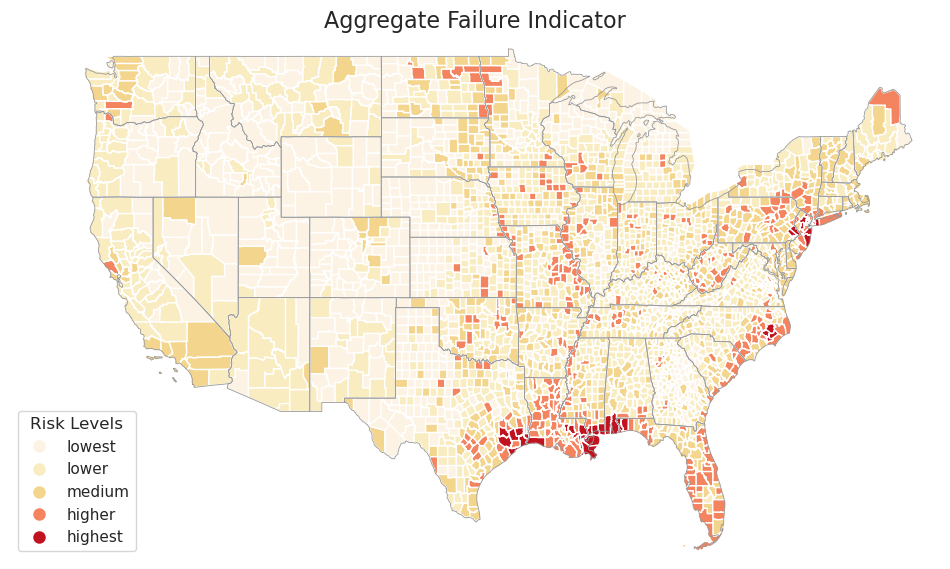

In [63]:
# Ensure numeric risk categories
risk_mapping = {label: i + 1 for i, label in enumerate(risk_levels)}
gdf_counties["Risk_Category_Num"] = gdf_counties["Risk_Category"].map(risk_mapping)

# Define discrete colors for each risk level
colors = ["#fdf3e4", "#f9ecc1", "#f4d58d", "#f4845f",  "#c1121f"]   # Example OrRd shades
cmap = ListedColormap(colors)

# Create boundary normalization so each color corresponds to a risk category
bounds = np.arange(1, len(risk_levels) + 2)  # [1, 2, 3, 4, 5, 6]
norm = BoundaryNorm(bounds, cmap.N)

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Plot the counties with corrected discrete colormap
gdf_counties.plot(column="Risk_Category_Num", cmap=cmap, norm=norm, legend=False, ax=ax)

# Manually create a legend with categorical labels
legend_labels = risk_levels
legend_colors = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
ax.legend(
    legend_colors, legend_labels, title="Risk Levels", loc="lower left", frameon=True
)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor="0.6", linewidth=0.6)

# Add title and adjust map extent
ax.set_title("Aggregate Failure Indicator", fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis("off")

# Show the plot
plt.show()

In [65]:
gdf_counties[['GEOID', 'Risk_Score', 'Risk_Category_Num']].to_csv('insolvency_risk.csv')

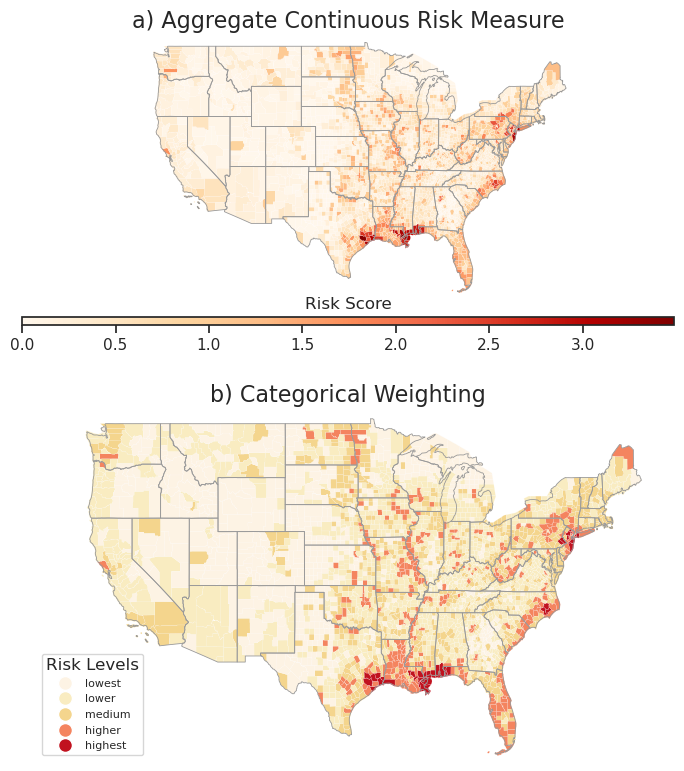

In [66]:
# Define extent and colormap
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
cmap = plt.cm.OrRd  # Continuous colormap for Risk Score

# Define discrete colormap for Risk Levels
colors = ["#fdf3e4", "#f9ecc1", "#f4d58d", "#f4845f",  "#c1121f"] # Example OrRd shades
discrete_cmap = mcolors.ListedColormap(colors)

# Create a figure with two stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(7, 8))  # 2 rows, 1 column of subplots

# === Plot 1: Risk Score (Continuous) ===
ax1 = axes[0]
divider = make_axes_locatable(ax1)

# Plot the continuous risk score
gdf_counties.plot(column='Risk_Score', cmap=cmap, legend=False, ax=ax1, linewidth=0.1)
gdf_states.boundary.plot(ax=ax1, edgecolor='0.6', linewidth=0.6)

# Configure plot 1
ax1.set_title('a) Aggregate Continuous Risk Measure', fontsize=16)
ax1.set_xlim(extent[0], extent[1])
ax1.set_ylim(extent[2], extent[3])
ax1.axis('off')

# Add colorbar below the first plot
vmin = gdf_counties['Risk_Score'].min()
vmax = gdf_counties['Risk_Score'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cax = divider.append_axes("bottom", size="3%", pad=0.2)  # Adjust size and padding
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cax, orientation='horizontal')
cax.set_title('Risk Score')

# === Plot 2: Risk Levels (Categorical) ===
ax2 = axes[1]

# Ensure Risk_Category is numerical and mapped correctly
risk_mapping = {label: i + 1 for i, label in enumerate(risk_levels)}
gdf_counties["Risk_Category_Num"] = gdf_counties["Risk_Category"].map(risk_mapping)

# Plot discrete categorical risk levels
gdf_counties.plot(column="Risk_Category_Num", cmap=discrete_cmap, legend=False, ax=ax2, linewidth=0.1)
gdf_states.boundary.plot(ax=ax2, edgecolor="0.6", linewidth=0.6)

# Manually create legend for categorical risk levels
legend_labels = risk_levels
legend_colors = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
    for color in colors
]
ax2.legend(
    legend_colors, legend_labels, title="Risk Levels", loc="lower left", frameon=True, fontsize=8
)

# Configure plot 2
ax2.set_title("b) Categorical Weighting", fontsize=16)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])
ax2.axis("off")

# Adjust layout and display
plt.tight_layout()

if save:
    output_path = 'Plots/F6_Aggregate_Risk.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

plt.show()

# Extensions

In [ ]:
def fuzzy_membership_function(value, level, thresholds):
    """
    Calculates the fuzzy membership degree of a value based on the level and thresholds.
    
    Parameters:
        value (float): The index value.
        level (int): The risk level (0 to 4 for 5 levels).
        thresholds (list of float): Critical values for the grading standard.
    
    Returns:
        float: Membership degree for the given value and level.
    """
    if level == 0:  # Lowest risk (descending semi-trapezoid)
        return max(0, min(1, (thresholds[1] - value) / (thresholds[1] - thresholds[0])))
    elif level == 4:  # Highest risk (ascending semi-trapezoid)
        return max(0, min(1, (value - thresholds[3]) / (thresholds[4] - thresholds[3])))
    else:  # Intermediate levels (triangular)
        left = thresholds[level - 1]
        center = thresholds[level]
        right = thresholds[level + 1]
        if value < center:
            return max(0, (value - left) / (center - left))
        else:
            return max(0, (right - value) / (right - center))


In [ ]:
# Step 6: Determine Grading Standards using K-means
kmeans = KMeans(n_clusters=5, random_state=42)
risk_scores = risk_scores.reshape(-1, 1)  # Reshape for K-means
kmeans.fit(risk_scores)
grading_standards = np.sort(kmeans.cluster_centers_.flatten())  # Sorted cluster centers as thresholds
print("Threshold Standards (K-means Cluster Centers):", threshold_standards)

In [ ]:
# Calculate fuzzy membership for each risk level
m = len(standardized_metrics)

# Initialize fuzzy evaluation matrix R
fuzzy_membership = np.zeros((len(gdf_counties), m))

for i, metric in enumerate(standardized_metrics):
    for j in range(m):
        fuzzy_membership[:, j] += gdf_counties[metric].apply(
            lambda x: fuzzy_membership_function(x, j, grading_standards)
        )

# Normalize membership degrees
fuzzy_membership = fuzzy_membership / fuzzy_membership.sum(axis=1, keepdims=True)

# Create evaluation matrix R
R = fuzzy_membership

In [ ]:
# Ensure R and CW are properly aligned
comprehensive_membership = R * CW  # Element-wise multiplication

In [ ]:
# Step 8: Assign Final Risk Levels
gdf_counties["Risk_Level"] = np.argmax(comprehensive_membership, axis=1)

# Define risk level labels
risk_levels = ["lowest", "lower", "medium", "higher", "highest"]
gdf_counties["Risk_Level_Label"] = gdf_counties["Risk_Level"].apply(lambda x: risk_levels[x])

In [ ]:
# Define discrete colors for each risk level
colors = ["#fdf0d5", "#f4d58d", "#f4845f", "#c1121f", "#780000"]  # Example OrRd shades
cmap = ListedColormap(colors)

# Ensure the order of Risk_Level_Label matches the color mapping
risk_levels = ["lowest", "lower", "medium", "higher", "highest"]  # Order matters here
gdf_counties["Risk_Level_Label"] = pd.Categorical(
    gdf_counties["Risk_Level_Label"], categories=risk_levels, ordered=True
)

In [ ]:
# Plot the Risk Level with discrete coloring
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Plot the counties with discrete coloring
gdf_counties.plot(column="Risk_Level_Label", cmap=cmap, legend=True, ax=ax)

# Customize legend for discrete categories
legend_labels = risk_levels
legend_colors = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
ax.legend(
    legend_colors, legend_labels, title="Risk Levels", loc="lower left", frameon=True
)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax, edgecolor="0.6", linewidth=0.6)

# Add title and adjust map extent
ax.set_title("Aggregate Failure Indicator", fontsize=16)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.axis("off")

# Show the plot
plt.show()

In [ ]:
# Define extent and color map
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
cmap = plt.cm.OrRd

# Create a figure with two stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(7, 8))  # 2 rows, 1 column of subplots

# Plot 1: Risk Score
ax1 = axes[0]
divider = make_axes_locatable(ax1)

# Plot the data
gdf_counties_plot = gdf_counties.plot(column='Risk_Score', cmap=cmap, legend=False, ax=ax1, linewidth=0.1)
gdf_states.boundary.plot(ax=ax1, edgecolor='0.6', linewidth=0.6)
ax1.set_title('a) Aggregate Continuous Risk Measure', fontsize=16)
ax1.set_xlim(extent[0], extent[1])
ax1.set_ylim(extent[2], extent[3])
ax1.axis('off')

# Calculate normalization for the colorbar
vmin = gdf_counties['Risk_Score'].min()
vmax = gdf_counties['Risk_Score'].max()
norm = Normalize(vmin=vmin, vmax=vmax)

# Add colorbar below the first plot
cax = divider.append_axes("bottom", size="3%", pad=0.2)  # Adjust size and padding
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cax, orientation='horizontal')
cax.set_title('Risk Score')

# Plot 2: Risk Level with discrete coloring
ax2 = axes[1]
gdf_counties.plot(column="Risk_Level_Label", cmap=cmap, legend=True, ax=ax2, linewidth=0.1)

# Customize legend for discrete categories
legend_labels = risk_levels
legend_colors = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
    for color in colors
]
ax2.legend(
    legend_colors, legend_labels, title="Risk Levels", loc="lower left", frameon=True, fontsize=8
)

gdf_states.boundary.plot(ax=ax2, edgecolor="0.6", linewidth=0.6)
ax2.set_title("b) Categorical Weighting", fontsize=16)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])
ax2.axis("off")

# Adjust layout and display
plt.tight_layout()

if save:
    output_path = 'Plots/F6_Aggregate_Risk.png'
    #plt.savefig(output_path, dpi=500, bbox_inches='tight')
    
plt.show()

# Isolate Loss Counties and Analyze

In [ ]:
county_demo = pd.read_csv("../Local_Data/County_Demographics/county_demographics.csv")
county_demo['FIPS'] = county_demo['FIPS'].astype(int).astype(str).str.zfill(5)

In [ ]:
# First, merge nfip with buyouts on 'countyCode' using a left join to keep all rows in nfip_losses
merged = gdf_counties.merge(county_demo, left_on='countyCode', right_on='FIPS', how='left')

# Demographics

In [ ]:
demo_type = '' 

In [ ]:
if demo_type == 'medium':
    medium_risk = gdf_counties[gdf_counties['Risk_Score'] > grading_standards[2]]
    print("Medium Risk Counties:")
    print(len(medium_risk))

    # First, merge nfip_losses with buyouts on 'countyCode' using a left join to keep all rows in nfip_losses
    merged_losses = medium_risk.merge(county_demo, left_on='countyCode', right_on='FIPS', how='left')
    
elif demo_type == 'higher':
    high_risk = gdf_counties[gdf_counties['Risk_Score'] > grading_standards[3]]
    print("\nHigh Risk Counties:")
    print(len(high_risk))

    # First, merge nfip_losses with buyouts on 'countyCode' using a left join to keep all rows in nfip_losses
    merged_losses = high_risk.merge(county_demo, left_on='countyCode', right_on='FIPS', how='left')

elif demo_type == 'hyper':
    hyper = gdf_counties[gdf_counties['hyperCount'] > 0]
    print("\nHyper Risk Counties:")
    print(len(hyper))

    # First, merge nfip_losses with buyouts on 'countyCode' using a left join to keep all rows in nfip_losses
    merged_losses = hyper.merge(county_demo, left_on='countyCode', right_on='FIPS', how='left')

else:
    at_loss = gdf_counties[gdf_counties['meanLoss'] <= 0]
    print("Loss Counties:")
    print(len(at_loss))

    # First, merge nfip_losses with buyouts on 'countyCode' using a left join to keep all rows in nfip_losses
    merged_losses = at_loss.merge(county_demo, left_on='countyCode', right_on='FIPS', how='left')

In [ ]:
# Define the desired order of the 'Urban_2013' categories
urban_order = ['Non-core', 'Micropolitan', 'Small Metro', 'Medium Metro', 'Large Fringe Metro', 'Large Central Metro']

# Ensure 'Urban_2013' is treated as a categorical variable with the specified order
merged_losses['Urban_2013'] = pd.Categorical(
    merged_losses['Urban_2013'], 
    categories=urban_order, 
    ordered=True
)

# Recompute the counts and aggregated values to respect the new category order
urban_counts = merged_losses['Urban_2013'].value_counts(sort=False)
urban_mean_loss = merged_losses.groupby('Urban_2013')['meanLoss'].sum()
urban_mean_loss_hh = merged_losses.groupby('Urban_2013')['lossPerInsured'].mean()

sns.set_theme(style="ticks")

# Set up the figure and subplots (3 rows, 2 columns) with adjusted width to 180mm (~7 inches)
fig, axes = plt.subplots(3, 2, figsize=(7, 7 * 1.5))

# Define a diverging color palette and map it to the unique urban classifications
palette = sns.color_palette("coolwarm", n_colors=len(urban_counts))
color_mapping = {urban: color for urban, color in zip(urban_counts.index, palette)}

# First subplot: Bar plot of counts with consistent colors
sns.barplot(x=urban_counts.index, y=urban_counts.values, palette=color_mapping, ax=axes[0, 0])
axes[0, 0].set_title(f'Count of Counties with NFIP Loss\n', fontsize=12)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('(#)', fontsize=10)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=8)
axes[0, 0].tick_params(axis='y', labelsize=8)
axes[0, 0].set_xticklabels([])  # Remove x-axis tick labels

# Second subplot: Bar plot of aggregated 'meanLoss' with the same colors and matching order
sns.barplot(x=urban_counts.index, y=urban_mean_loss[urban_counts.index]/1000000, palette=color_mapping, ax=axes[1, 0])
axes[1, 0].set_title('Expected NFIP Loss', fontsize=12)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('($M/yr)', fontsize=10)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=8)
axes[1, 0].tick_params(axis='y', labelsize=8)
axes[1, 0].set_xticklabels([])  # Remove x-axis tick labels

# Third subplot: Bar plot of aggregated 'meanLoss' per insured household with the same colors and matching order
sns.barplot(x=urban_counts.index, y=urban_mean_loss_hh[urban_counts.index], palette=color_mapping, ax=axes[2, 0])
axes[2, 0].set_title('Household Expected NFIP Loss', fontsize=12)
axes[2, 0].set_xlabel('Urban Classification', fontsize=10)
axes[2, 0].set_ylabel('($/yr)', fontsize=10)
axes[2, 0].tick_params(axis='x', rotation=45, labelsize=8)
axes[2, 0].tick_params(axis='y', labelsize=8)

# Define the columns to plot and their corresponding titles
columns_to_plot = {
    "Median_Household_Income_2021": "Median Household Income ($)",
    "R_POVALL_2021": "Poverty Rate (%)",
    "R_NET_MIG_2023": "Net Migration Rate (%)",
}

# Define pastel color palette
palette = sns.color_palette("pastel")

# Define darker colors for text
darker_palette = sns.color_palette("dark")

# Plot the second column: Median Household Income, Percent of Claims Filed by Mitigated Properties, Net Migration Rate
for i, (column, title) in enumerate(columns_to_plot.items()):
    row = i  # Align with the row in the first column
    col = 1  # All in the second column
    
    # Calculate medians
    overall_median = merged[column].median()
    filtered_median = merged_losses[column].median()
    
    # Calculate 5th and 95th percentiles for setting x-axis limits
    overall_1st = merged[column].quantile(0.01)
    overall_99th = merged[column].quantile(0.99)
    
    # Perform t-test
    t_stat, p_value = ttest_ind(merged[column].dropna(), merged_losses[column].dropna())
    
    # Plot the overall distribution
    sns.kdeplot(merged[column], ax=axes[row, col], label='All US Counties', color=palette[0], fill=True, alpha=0.3)
    axes[row, col].axvline(overall_median, color=palette[0], linestyle='--', linewidth=2, label='All US Counties Median')
    
    # Plot the filtered distribution
    sns.kdeplot(merged_losses[column], ax=axes[row, col], label='NFIP Net Loss Counties', color=palette[1], fill=True, alpha=0.3)
    axes[row, col].axvline(filtered_median, color=palette[1], linestyle='--', linewidth=2, label='NFIP Net Loss Counties Median')
    
    # Set x-axis limits to be between the 5th and 95th percentiles
    axes[row, col].set_xlim(overall_1st, overall_99th)
    
    # Set the title and labels
    axes[row, col].set_title(f'{title}', fontsize=12)
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('Density', fontsize=10)
    axes[row, col].tick_params(axis='x', labelsize=8)
    axes[row, col].tick_params(axis='y', labelsize=8)
    
    # Add p-value as text label in the upper center
    axes[row, col].text(0.5, 0.9, f'P-Value: {p_value:.3f}', transform=axes[row, col].transAxes, style='italic', color='grey', fontsize=8, ha='center')
    
    # Label the medians with their values
    axes[row, col].text(overall_median, axes[row, col].get_ylim()[1] * 0.8, f'{overall_median:.0f}', fontsize=8, color=darker_palette[0], ha='center')
    axes[row, col].text(filtered_median, axes[row, col].get_ylim()[1] * 0.7, f'{filtered_median:.0f}', fontsize=8, color=darker_palette[1], ha='center')

    # Set y-axis formatter to prevent scientific notation
    axes[row, col].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[row, col].yaxis.get_offset_text().set_fontsize(8)  # Adjust offset text size
    
# Create a common legend below the third plot in the second column
handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=8, ncol=1, bbox_to_anchor=(0.75, 0.02))

# Add bold subplot labels
subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for ax, label in zip(axes.flat, subplot_labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Adjust layout for better spacing
plt.tight_layout(pad=1)

# Save the plot with 500 dpi
if save:
    output_path = 'Plots/SI/F1_Demographics.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Show the plots
plt.show()